# Tarea 5 - RNN GRU LSTM

### ITESM - Escuela de Ingeniería y Ciencias
#### Maestría en Ciencias Computacionales
#### Tópicos AI 2
##### Dr. Luis Eduardo Falcón Morales

---

## Carlos E. Hdz Rincón - A01181616

# Introducción

Esta Tarea se podrá resolver de manera individual o en equipos de máximo 3 integrantes.

Esta Tarea se basa en los datos de Kaggle, Question Classification: Android or iOS: https://www.kaggle.com/xhlulu/question-classification-android-or-ios?select=train.csv

Podrás encontrar la descipción de los datos en dicha liga. Descarga los archivos `train.csv`, `val.csv` y `test.csv`.


# Prerequisitos y preparamiento de ambiente

## Instalación de dependencias

Descomentamos la siguiente línea para poder instalar las dependencias de Python necesarias.

In [ ]:
#!pip install keras tensorflow matplotlib numpy pandas

## Extracción de datos a partir del archivo ZIP

In [ ]:
# Set this variable to the root path of where the CSV files are located
#%env DATA_LOCATION=/workspace/jupyter_workspace/datasets/AndroidOriOS
%env DATA_LOCATION=/content/drive/MyDrive/Datasets/AndroidOrIos
!echo $DATA_LOCATION

#!unzip "$DATA_LOCATION/kaggle-dataset.zip" -d "$DATA_LOCATION"

!ls -lah "$DATA_LOCATION"

env: DATA_LOCATION=/content/drive/MyDrive/Datasets/AndroidOrIos
/content/drive/MyDrive/Datasets/AndroidOrIos
total 76M
-rw------- 1 root root 2.5M Apr 29 20:57 ios_android_rnn_best_model_final.pkl
-rw------- 1 root root 3.0M Apr 29 19:42 ios_android_rnn_gru_ltsm.pkl
-rw------- 1 root root  19M Apr 20 19:59 kaggle-dataset.zip
-rw------- 1 root root 7.8M Oct 29  2020 test.csv
-rw------- 1 root root  37M Oct 29  2020 train.csv
-rw------- 1 root root 7.7M Oct 29  2020 valid.csv


## Imports

In [ ]:
from IPython.display import display

import time
import random
import os
import re

from collections import Counter
import itertools 
from itertools import chain


import numpy as np
import pandas as pd
import pickle

import matplotlib
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.model_selection import train_test_split  
from sklearn.metrics import confusion_matrix, classification_report

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM, Bidirectional, RNN, GRU, SimpleRNN

import tensorflow as tf

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

# Connect to Google Drive if hosting the files there
#from google.colab import drive
#drive.mount('/content/drive')

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Tools

In [ ]:
negative_words = ['no', 'nor', 'not',
                  'ain', "ain't", "aint",
                  'aren', "aren't", "arent",
                  'don', "don't", "dont",
                  'couldn', "couldn't", "couldnt",
                  'didn', "didn't", "didnt",
                  'doesn', "doesn't", "doesnt",
                  'hadn', "hadn't", "hadnt",
                  'hasn', "hasn't", "hasnt",
                  'haven', "haven't", "havent",
                  'isn', "isn't",  "isnt",
                  'mightn', "mightn't", "mightnt",
                  'mustn', "mustn't", "mustnt",
                  'needn', "needn't", "neednt",
                  'shan', "shan't", "shant",
                  'shouldn', "shouldn't", "shouldnt",
                  'wasn', "wasn't", "wasnt",
                  'weren', "weren't", "werent",
                  'won', "won't", "wont",
                  'wouldn', "wouldn't", "wouldnt",
                  "can't", "cant"]

my_stopwords = [ w for w in stopwords.words('english') if w not in negative_words]
#my_stopwords = stopwords.words("english")

In [ ]:
def print_marquee(msg: str):
    """
    Prints a centered message with a marquee of * 
    """
    marquee_width = len(msg) + 4
    print("\n")
    print("*" * marquee_width)
    print(f"* {msg} *")
    print("*" * marquee_width)

In [ ]:
def model_2_pkl(model, filename: str):
    """Exports a model to PKL format"""
    pickle.dump(model, open(filename, 'wb'))

def pkl_2_model(filename: str):
    """Loads a model from a PKL file"""
    return pickle.load(open(filename, 'rb'))

def train_model(model_to_fit: tf.keras.models.Model,
                epochs: int,
                train_data: tuple,
                validation_data: tuple,
                callbacks: list = None,
                batch_size=None):

    t = time.process_time()
    
    trained_model = model_to_fit.fit(train_data[0],
                                     train_data[1],
                                     validation_data=validation_data,
                                     epochs=epochs,
                                     callbacks=callbacks,
                                     batch_size=batch_size)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model

def graph_loss_accuracy(h_model,
                        subtitle: str = ""):
    
    num_records = len(h_model.history["accuracy"])
    
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,num_records),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,num_records),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,num_records),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(y_pred,
                                    y_real,
                                    labels: list=None):
    
    y_pred = np.round(y_pred).astype(int)

    print_marquee("Classification Report")
    print(classification_report(y_real,
                                y_pred,
                                target_names=labels))
    
    print_marquee("Confusion Matrix")
    print(confusion_matrix(y_real,
                           y_pred))


def evaluate_model(model_to_fit: tf.keras.models.Model,
                   epochs: int,
                   train_tuple: tuple,
                   validation_tuple: tuple,
                   test_tuple: tuple = None,
                   callbacks: list = None,
                   batch_size = None,
                   labels: list = None) -> tf.keras.models.Model:

    trained_model_history = train_model(model_to_fit,
                                epochs,
                                train_tuple,
                                validation_tuple,
                                callbacks=callbacks,
                                batch_size=batch_size)
    print_marquee("Model Summary")                                
    model_to_fit.summary()

    print_marquee("Validation Dataset Confusion Matrix")

    val_model_predictions = model_to_fit.predict(validation_tuple[0],
                                                 batch_size=batch_size)
    
    print_dataset_prediction_report(val_model_predictions,
                                    validation_tuple[1],
                                    labels)


    if test_tuple:

        print_marquee("Test Dataset Confusion Matrix")

        test_model_predictions = model_to_fit.predict(test_tuple[0],
                                                      batch_size=batch_size)
        
        print_dataset_prediction_report(test_model_predictions,
                                        test_tuple[1],
                                        labels)

    print_marquee("Train/Val Accuracy and Loss graphs")

    # If using early stopping, it might be the case that we used less epochs than
    #  requested
    subtitle = f"Epochs: {len(trained_model_history.history['accuracy'])}"
    
    graph_loss_accuracy(trained_model_history,
                        subtitle=subtitle)
    
    return model_to_fit, trained_model_history

In [ ]:
def clean_text(txt: str,
               stopwords: list = [],
               token_min_length: int = None,
               stemmer = None) -> str:
    # Remove <code> tags make sure that the . char matches all characters
    code_regex = re.compile("<code>.*?<\/code>", re.DOTALL)
    txt = re.sub(code_regex, "", txt)

    # Remove HTML
    html_regex = re.compile('<.*?>')
    txt = re.sub(html_regex, '', txt)

    # To lower
    txt = txt.lower()

    # Reduce multiple spaces to just one
    multiple_spaces_regex = " +"
    txt = re.sub(multiple_spaces_regex, ' ', txt).strip()

    # Optionally remove stop words
    if stopwords:
        txt = " ".join([t for t in txt.split() if t not in stopwords])

    # Remove non-alphanumeric characters
    non_alphanumeric_regex = "[^a-zA-Z0-9 ]"
    txt = re.sub(non_alphanumeric_regex, '', txt)

    if token_min_length:
        txt = " ".join([t for t in txt.split() if len(t) >= token_min_length])

    if stemmer:
        txt = " ".join([stemmer.stem(t) for t in txt.split()])

    # Remove any extra spaces that may have been left behind
    multiple_spaces_regex = " +"
    txt = re.sub(multiple_spaces_regex, ' ', txt).strip()

    return txt


def clean_up_column(train: pd.DataFrame,
                    val: pd.DataFrame,
                    test: pd.DataFrame,
                    column_to_clean: str,
                    stop_words: list = [],
                    token_min_length: int = 2,
                    stemmer = None,
                    print_data_preview: bool = True,
                    create_data_copy: bool = True) -> tuple:


    if create_data_copy:
        train_new = train.copy()
        val_new = val.copy()
        test_new = test.copy()
    else:
        train_new = train
        val_new = val
        test_new = test

    train_new[column_to_clean] = train_new[column_to_clean].apply(lambda row_text: clean_text(row_text,
                    stopwords = stop_words,
                    token_min_length = token_min_length,
                    stemmer = stemmer))

    val_new[column_to_clean] = val_new[column_to_clean].apply(lambda row_text: clean_text(row_text,
                    stopwords = stop_words,
                    token_min_length = token_min_length,
                    stemmer = stemmer))

    test_new[column_to_clean] = test_new[column_to_clean].apply(lambda row_text: clean_text(row_text,
                    stopwords = stop_words,
                    token_min_length = token_min_length,
                    stemmer = stemmer))

    if print_data_preview:
        print_marquee("Train")
        display(train_new[[column_to_clean]].head(5))

        print_marquee("Val")
        display(val_new[[column_to_clean]].head(5))

        print_marquee("Test")
        display(test_new[[column_to_clean]].head(5))

    return train_new, val_new, test_new


def get_token_sequences(train: pd.DataFrame,
                        val: pd.DataFrame,
                        test: pd.DataFrame,
                        column_to_process: str,
                        min_freq: int = 50):

    tokenizer = Tokenizer(
        num_words=None,
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        char_level=False,
        oov_token="[OOV]"
    )

    # Create a temporal copy so as to not affect the original DataFrame
    train = train.copy()

    tokenizer.fit_on_texts(train[column_to_process])

    # Remove 1 as the tokenizer reserves but doesn't use index 0
    raw_vocab_size = len(tokenizer.word_index) - 1

    print_marquee("Raw Vocabulary Statistics")

    print(f"Raw vocabulary size: {raw_vocab_size}")

    # Let's plot the graph of the dictionary size from more frequent to less frequent
    plt.plot(list(np.arange(raw_vocab_size)), list(tokenizer.word_docs.values()), color='blue')
    plt.show()

    # Let's reduce the list of words to those that happen at least min_freq

    my_vocab = {word: count for word, count in tokenizer.word_docs.items() if count >= min_freq}

    print_marquee(f"My vocabulary reduced to words that happen at least {min_freq} times")

    print(f"New vocabulary size reduced to words happening at least {min_freq} times: {len(my_vocab)}")
    print(f"Represents a reduction of {(1 - len(my_vocab)/raw_vocab_size) * 100}% \n")

    plt.plot(list(np.arange(len(my_vocab))), list(my_vocab.values()), color='blue')
    plt.show()

    # Filter out words not in vocabulary
    train[column_to_process] = train[column_to_process].apply(lambda row_text: filter_words_not_in_vocab(row_text, my_vocab))

    # Create another tokenizer based on the newly formed vocabulary
    tokenizer = Tokenizer(
        num_words=len(my_vocab),
        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
        lower=True,
        split=" ",
        char_level=False,
        oov_token="[OOV]"
    )

    tokenizer.fit_on_texts(train[column_to_process])

    train_sequences = tokenizer.texts_to_sequences(train[column_to_process])
    validation_sequences = tokenizer.texts_to_sequences(val[column_to_process])
    test_sequences = tokenizer.texts_to_sequences(test[column_to_process])

    print_marquee("My Vocabulary Tokenizer Statistics")

    # We need to substract 1 to account for the 0-index unused token (Keras reserves this but doesn't use it)
    print(f"Tokenizer vocabulary size: {len(tokenizer.word_index) - 1} (compared to {len(my_vocab)} of the my vocab size)")

    return train_sequences, validation_sequences, test_sequences


def calculate_document_length_metrics(train: pd.DataFrame,
                                      val: pd.DataFrame,
                                      column: str):
    train_doc_len = pd.Series([len(doc.split()) for doc in train[column].tolist()])
    val_doc_len = pd.Series([len(doc.split()) for doc in val[column].tolist()])

    print_marquee("Train Metrics")
    print(f"Number of documents: {len(train_doc_len)}")
    print(f"Min length: {train_doc_len.min()}")
    print(f"Max length: {train_doc_len.max()}")
    print(f"Mean length: {train_doc_len.mean()}")
    print(f"Std Dev of length: {train_doc_len.std()}")

    print_marquee("Val Metrics")
    print(f"Number of documents: {len(val_doc_len)}")
    print(f"Min length: {val_doc_len.min()}")
    print(f"Max length: {val_doc_len.max()}")
    print(f"Mean length: {val_doc_len.mean()}")
    print(f"Std Dev of length: {val_doc_len.std()}")

# Parte I: Lecturas 

Realiza un resumen de máximo una cuartilla cada una de las siguientes tres lecturas:
1. A Systematic Review on Stopword Removal Algorithms: http://www.ijfrcsce.org/index.php/ijfrcsce/article/view/1499
1. Pulling Out the Stops: Rethinking Stopword Removal for Topic Models: https://www.aclweb.org/anthology/E17-2069.pdf
1. Normalizing Text using Language Modelling based on Phonetics and String Similarity: https://arxiv.org/abs/2006.14116

---
Resúmenes encontrados en un PDF anexo.

# Parte II: Pre-procesamiento con Body y sin excluir stopwords.

## Carga de datos

In [ ]:
data_root_location = os.environ["DATA_LOCATION"]

train_data = pd.read_csv(f"{data_root_location}/train.csv")
val_data = pd.read_csv(f"{data_root_location}/valid.csv")
test_data = pd.read_csv(f"{data_root_location}/test.csv")

print_marquee("Train")
display(train_data.head(5))
display(train_data.info())

print_marquee("Val")
display(val_data.head(5))
display(val_data.info())

print_marquee("Test")
display(test_data.head(5))
display(test_data.info())




*********
* Train *
*********


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,197234,Drop\stop mobile data connection (non-wifi) by...,<p>Can I set Android 4.4.2 to drop mobile data...,0,34,android,0
1,114800,How to automatically crop text messages when S...,<p>Is there a way to prevent the Messages app ...,0,836,android,0
2,124532,Can't find text message that was to a group,<p>When John Doe texts to a group that include...,1,28,android,0
3,193875,Can't store contacts on my Android phone,<p>I was going through all of my installed app...,0,158,android,0
4,50332,Dropbox on Samsung Galaxy - where is the Setti...,"<p>On a Sony Xperia, the settings button in Dr...",1,963,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51370 entries, 0 to 51369
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         51370 non-null  int64 
 1   Title      51370 non-null  object
 2   Body       51370 non-null  object
 3   Score      51370 non-null  int64 
 4   ViewCount  51370 non-null  int64 
 5   Label      51370 non-null  object
 6   LabelNum   51370 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 2.7+ MB


None



*******
* Val *
*******


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,282570,How to erase my iPhone photos completely?,<p>I decided to delete all of my iPhone's phot...,1,95,ios,1
1,151903,How can i Downgrade my Lg G Flex 2?,<p>Is it possible for me to downgrade to kitka...,0,695,android,0
2,16128,How can I make 1Password for Android log in wi...,<p>I have a Droid X and have just installed 1P...,1,586,android,0
3,33177,Handwrite / draw on a text document,<p>Is there an Android app that enables hand-w...,0,7340,android,0
4,65171,"How to turn off ""applying profile"" and ""profil...",<p>Whenever a new profile is applied there is ...,0,519,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11008 entries, 0 to 11007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         11008 non-null  int64 
 1   Title      11008 non-null  object
 2   Body       11008 non-null  object
 3   Score      11008 non-null  int64 
 4   ViewCount  11008 non-null  int64 
 5   Label      11008 non-null  object
 6   LabelNum   11008 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 602.1+ KB


None



********
* Test *
********


,Id,Title,Body,Score,ViewCount,Label,LabelNum
0,202290,How to disable usage of background data of all...,<p>Some networks charges high in cellular data...,1,5785,android,0
1,151626,Low space On my Android,<p>I have a LG android and I bought a sd card ...,1,130,android,0
2,129401,Voice Memos (ios app) recording to Google Drive,<p>Is there any way to upload the Voice Memos ...,2,36111,ios,1
3,332306,Transfer IPA file to iPhone,<p>I'm using Cydia Impactor and wish to copy a...,0,478,ios,1
4,34587,"Can't move any applications to SD Card- ""Could...",<p>I'm trying to move any application that I i...,3,3895,android,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11008 entries, 0 to 11007
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         11008 non-null  int64 
 1   Title      11008 non-null  object
 2   Body       11008 non-null  object
 3   Score      11008 non-null  int64 
 4   ViewCount  11008 non-null  int64 
 5   Label      11008 non-null  object
 6   LabelNum   11008 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 602.1+ KB


None

## 2 Limpieza de Body

Realiza un proceso de limpieza de la columna `Body` del conjunto de entrenamiento. Aplica las expresiones regulares que consideres adecuadas, sin excluir las Stopwords.

NOTA: Deberás decidir las expresiones regulares o signos ortográficos a considerar dentro del proceso de limpieza, pero recuerda que debes decidirlo procesando únicamente los datos de entrenamiento. Y una vez definido, lo aplicas directamente al conjunto de validación.

---


Primero tomamos un ejemplo aleatorio para ver cómo se ve el texto.

In [ ]:
train_data["Body"][1988]

'<p>I have a GT-I9195 running Lollipop 5.1.1 (currently PAC-ROM) which in theory has 8GB of internal memory. However, I can\'t seem to track down what exactly has happened to all that space. With a paltry 100 or so apps (including system essentials) installed, the phone starts reporting it\'s out of space until I move apps to the external MicroSD card. The problem persisted even through the custom ROM installation and subsequent recent ROM update as well as a few factory resets/cache wipes/etc. It\'s been an issue for nearly 8 months now, and periodically I\'ve trawled the Internet for suggestions and clues but without making any real progress.</p>\n\n<p>It seems to me as if a large chunk of space on the phone\'s memory is simply inaccessible and unused. Is this possible? How can I delve deeper into what\'s going on?</p>\n\n<p>I\'ve included the output of a df command in terminal emulator below. I notice that there seem to be duplicates of the internal memory /storage/emulated/0 and /s

Podemos confirmar que el texto tiene tags HTML incluso con atributos, además podemos también ver que hay caracteres de salto de línea. Además, vemos que el texto posee signos de puntuación como puntos, comas y paréntesis.

Debemos preservar la infomación que esté entre paréntesis, pero debemos eliminar los tags HTML y todos los atributos que estén dentro de ellos ya que no proporcionan información significativa para la extracción de features.

Los tags como `<strong></strong>` poseen texto entre ellos que sí será interesante conservar, pero debemos tener especial cuidado de remover todo lo que se encuentre entre los tags `<code></code>` ya que posee código que no aportará mucho a nuestro modelo.

Debemos tener también cuidado en que al remover las palabras inválidas no agreguemos más espacios en blanco entre las palabras y, de hecho, debemos remover cualquier espacio extra que ya se encuentre en el texto.

Para hacer la limpieza haremos lo siguiente en el siguiente orden:

1. Remover todos los tags que contengan código (`<code></code>`)
1. Remover todos los tags HTML y sus atributos, pero preservar el contenido entre los tags (`<p>, <strong>`, etc.)
1. Quitar todos los símbolos de salto de línea que se encuentran en el texto.
1. Quitar todos los caracteres que no sean alfanuméricos a excepción de los espacios en blanco.
1. Quitar todo el espacio extra que pueda haber entre todas las palabras.
1. Pasar todo el texto a minúsculas para poder procesar tokens más consistentemente.

In [ ]:
txt_sample = train_data["Body"][1988]

print_marquee("Before cleaning up:")
print(txt_sample)

print_marquee("After cleaning up:")
print(clean_text(txt_sample))



***********************
* Before cleaning up: *
***********************
<p>I have a GT-I9195 running Lollipop 5.1.1 (currently PAC-ROM) which in theory has 8GB of internal memory. However, I can't seem to track down what exactly has happened to all that space. With a paltry 100 or so apps (including system essentials) installed, the phone starts reporting it's out of space until I move apps to the external MicroSD card. The problem persisted even through the custom ROM installation and subsequent recent ROM update as well as a few factory resets/cache wipes/etc. It's been an issue for nearly 8 months now, and periodically I've trawled the Internet for suggestions and clues but without making any real progress.</p>

<p>It seems to me as if a large chunk of space on the phone's memory is simply inaccessible and unused. Is this possible? How can I delve deeper into what's going on?</p>

<p>I've included the output of a df command in terminal emulator below. I notice that there seem to b

In [ ]:
train_data_2 = train_data.copy()
val_data_2 = val_data.copy()
test_data_2 = test_data.copy()

train_data_2["Body"] = train_data_2["Body"].apply(lambda row_text: clean_text(row_text))
val_data_2["Body"] = val_data_2["Body"].apply(lambda row_text: clean_text(row_text))
test_data_2["Body"] = test_data_2["Body"].apply(lambda row_text: clean_text(row_text))

print_marquee("Train")
display(train_data_2[["Body"]].head(5))

print_marquee("Val")
display(val_data_2[["Body"]].head(5))

print_marquee("Test")
display(test_data_2[["Body"]].head(5))



*********
* Train *
*********


,Body
0,can i set android 442 to drop mobile data conn...
1,is there a way to prevent the messages app fro...
2,when john doe texts to a group that includes m...
3,i was going through all of my installed applic...
4,on a sony xperia the settings button in dropbo...




*******
* Val *
*******


,Body
0,i decided to delete all of my iphones photos s...
1,is it possible for me to downgrade to kitkat i...
2,i have a droid x and have just installed 1pass...
3,is there an android app that enables handwriti...
4,whenever a new profile is applied there is a s...




********
* Test *
********


,Body
0,some networks charges high in cellular dataso ...
1,i have a lg android and i bought a sd card bec...
2,is there any way to upload the voice memos rec...
3,im using cydia impactor and wish to copy an ip...
4,im trying to move any application that i insta...


## 3 Tokenización

Realiza un proceso de tokenización del conjunto de entrenamiento y define tu vocabulario usando el conjunto de entrenamiento. Deberás indicar la frecuencia mínima requerida de cada token para que sea parte del vocabulario. Además usar la opción OOV_token en el proceso de tokenización para las palabras que nuevas no incluidas en el voabulario. Una vez transformado el conjunto de entrenamiento en secuencia de enteros, aplica el resultado obtenido al conjunto de validación.



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 131701


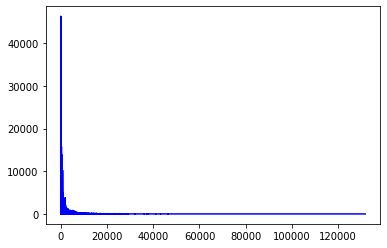

In [ ]:
tokenizer = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="[OOV]"
)

tokenizer.fit_on_texts(train_data_2["Body"])

# Remove 1 as the tokenizer reserves but doesn't use index 0
raw_vocab_size = len(tokenizer.word_index) - 1

# Summary of metrics:
#print(tokenizer.word_counts)
#print(tokenizer.document_count)
#print(tokenizer.word_index)
#print(tokenizer.word_docs)

print_marquee("Raw Vocabulary Statistics")

print(f"Raw vocabulary size: {raw_vocab_size}")

# Let's plot the graph of the dictionary size from more frequent to less frequent
plt.plot(list(np.arange(raw_vocab_size)), list(tokenizer.word_docs.values()), color='blue')
plt.show()



****************************************************************
* My vocabulary reduced to words that happen at least 50 times *
****************************************************************
New vocabulary size reduced to words happening at least 50 times: 3655
Represents a reduction of 97.22477429935992% 



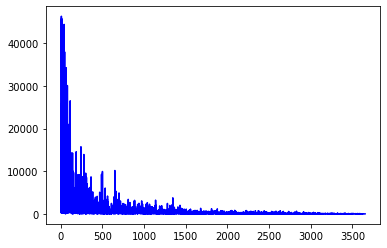

In [ ]:
# Let's reduce the list of words to those that happen at least min_freq
min_freq = 50

my_vocab = {word: count for word, count in tokenizer.word_docs.items() if count >= min_freq}

print_marquee(f"My vocabulary reduced to words that happen at least {min_freq} times")

print(f"New vocabulary size reduced to words happening at least {min_freq} times: {len(my_vocab)}")
print(f"Represents a reduction of {(1 - len(my_vocab)/raw_vocab_size) * 100}% \n")

plt.plot(list(np.arange(len(my_vocab))), list(my_vocab.values()), color='blue')
plt.show()

In [ ]:
def filter_words_not_in_vocab(text: str, vocabulary:dict) -> str:
    return " ".join([w for w in text.split() if w in vocabulary])

train_data_3 = train_data_2.copy()

train_data_3["Body"] = train_data_3["Body"].apply(lambda row_text: filter_words_not_in_vocab(row_text, my_vocab))

print(train_data_2.iloc[1988]["Body"])
print(train_data_3.iloc[1988]["Body"])


i have a gti9195 running lollipop 511 currently pacrom which in theory has 8gb of internal memory however i cant seem to track down what exactly has happened to all that space with a paltry 100 or so apps including system essentials installed the phone starts reporting its out of space until i move apps to the external microsd card the problem persisted even through the custom rom installation and subsequent recent rom update as well as a few factory resetscache wipesetc its been an issue for nearly 8 months now and periodically ive trawled the internet for suggestions and clues but without making any real progressit seems to me as if a large chunk of space on the phones memory is simply inaccessible and unused is this possible how can i delve deeper into whats going onive included the output of a df command in terminal emulator below i notice that there seem to be duplicates of the internal memory storageemulated0 and storageemulatedlegacy though i think one is just an alias of the ot

In [ ]:
# Create another tokenizer based on the newly formed vocabulary
tokenizer = Tokenizer(
    num_words=len(my_vocab),
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ",
    char_level=False,
    oov_token="[OOV]"
)

tokenizer.fit_on_texts(train_data_3["Body"])

train_sequences = tokenizer.texts_to_sequences(train_data_3["Body"])
validation_sequences = tokenizer.texts_to_sequences(val_data_2["Body"])
test_sequences = tokenizer.texts_to_sequences(test_data_2["Body"])

print_marquee("My Vocabulary Tokenizer Statistics")

# We need to substract 1 to account for the 0-index unused token (Keras reserves this but doesn't use it)
print(f"Tokenizer vocabulary size: {len(tokenizer.word_index) - 1} (compared to {len(my_vocab)} of the my vocab size)")

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_3.iloc[1988]['Body']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {val_data_2.iloc[1988]['Body']}\n {validation_sequences[1988]}")



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 3655 (compared to 3655 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 i have a running lollipop 511 currently which in theory has 8gb of internal memory however i cant seem to track down what exactly has happened to all that space with a 100 or so apps including system installed the phone starts reporting its out of space until i move apps to the external microsd card the problem even through the custom rom installation and recent rom update as well as a few factory its been an issue for nearly 8 months now and periodically ive the internet for suggestions and clues but without making any real seems to me as if a large of space on the phones memory is simply and unused is this possible how

In [ ]:
print_marquee(f"First 50 word-index mappings")
print(dict(itertools.islice(tokenizer.index_word.items(), 50)))



********************************
* First 50 word-index mappings *
********************************
{1: '[OOV]', 2: 'the', 3: 'i', 4: 'to', 5: 'and', 6: 'a', 7: 'it', 8: 'my', 9: 'is', 10: 'on', 11: 'in', 12: 'that', 13: 'of', 14: 'have', 15: 'this', 16: 'but', 17: 'for', 18: 'phone', 19: 'with', 20: 'not', 21: 'can', 22: 'or', 23: 'app', 24: 'from', 25: 'an', 26: 'android', 27: 'there', 28: 'be', 29: 'when', 30: 'as', 31: 'do', 32: 'if', 33: 'so', 34: 'any', 35: 'are', 36: 'how', 37: 'was', 38: 'all', 39: 'device', 40: 'iphone', 41: 'me', 42: 'using', 43: 'apps', 44: 'like', 45: 'im', 46: 'which', 47: 'use', 48: 'am', 49: 'get', 50: 'way'}


Podemos ver que el mapping de tokens a un índice se está realizando correctamente. Más aún, ya que el vocabulario del tokenizer fue entrenado exclusivamente en el dataset de entrenamiento, por definición el OOV token que hemos definido como `[OOV]` no aparecerá en las secuencias de sus documentos.

Sin embargo, en los datasets de validación y de entrenamiento esto sí pasa y podemos ver que al token `[OOV]` se le asignó el índice `1` y que este token sí aparece en el documento de validación.

## 4 Vectorización

Transforma cada documento de la columna Body del conjunto de entrenamiento, a una vector de longitud  finita  mediante  la  función pad_sequences  de  tensorflow-keras.  Al  menos  deberás determinar e indicar cuáles consideras son los mejores valores para los argumentos maxlen y 
padding.  Una  vez  determinado  los  argumentos  de  dicha  función,  aplicarlo  al  conjunto  de validación.


---

Para poder determinar un valor óptimo convendría calcular las longitudes de todos los documentos (en función de su cantidad de palabras) y revisar sus:

1. Mínimos
1. Máximos
1. Promedio
1. Desviación estándard

Para poder poner idealmente un valor que esté en el promedio. El tipo de padding que se usará será post sólo para mantener la información significativa del vector de secuencias al principio del vector.

In [ ]:
train_doc_len = pd.Series([len(doc.split()) for doc in train_data_3['Body'].tolist()])
val_doc_len = pd.Series([len(doc.split()) for doc in val_data_2['Body'].tolist()])

print_marquee("Train Metrics")
print(f"Number of documents: {len(train_doc_len)}")
print(f"Min length: {train_doc_len.min()}")
print(f"Max length: {train_doc_len.max()}")
print(f"Mean length: {train_doc_len.mean()}")
print(f"Std Dev of length: {train_doc_len.std()}")

print_marquee("Val Metrics")
print(f"Number of documents: {len(val_doc_len)}")
print(f"Min length: {val_doc_len.min()}")
print(f"Max length: {val_doc_len.max()}")
print(f"Mean length: {val_doc_len.mean()}")
print(f"Std Dev of length: {val_doc_len.std()}")




*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 0
Max length: 1221
Mean length: 86.33375510998637
Std Dev of length: 67.22154954977424


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 3
Max length: 1447
Mean length: 91.31077398255815
Std Dev of length: 71.296881944177


Podemos ver que en el dataset de entrenamiento tenemos documentos que carecen de texto en Body, esto se debe a que habían tokens inválidos (como posts que sólo tenían bloques `<code>` y que fueron removidos durante el pre-procesamiento.

Por ahora dejaremos los registros en el dataset y dejar que el padding rellene todas sus posiciones, podemos remover estos registros durante el entrenamiento si vemos que están introduciendo ruido.

No hay muchos registros en este caso y nos permitirá ver si el padding está funcionando.

In [ ]:
train_data_3[train_data_3["Body"].str.split().str.len() < 1]

,Id,Title,Body,Score,ViewCount,Label,LabelNum
25310,247464,Found in diagnostics on an iPhone 6s Plus. Any...,,0,2302,ios,1
37077,222200,Sahara fails when flashing CN ROM,,0,662,android,0
44395,176884,Why does googlequicksearchbox use so much memory?,,0,453,android,0


Las métricas que acabamos de recopilar en el dataset de prueba y validación nos muestran que el promedio de cuenta de palabras por documento es de alrededor de 86-91 con una desviación estándar para los dos datasets de alrededor de 70.

Con esto, podemos definir la longitud máxima de nuestros documentos a 150, lo que nos permitirá cubrir la mayor parte de los documentos en el dataset sin introducir padding o truncado excesivo.

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 150

train_padded = pad_sequences(train_sequences,
                             maxlen = max_len_vector,
                             padding = padding_type,
                             truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                           maxlen = max_len_vector,
                           padding = padding_type,
                           truncating = padding_type)

print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")

print_marquee("Sample of a record with no body")
print(f"Padded: {train_padded[25310]}")




************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [3, 59, 4, 69, 32, 6, 521, 659, 46, 62, 113, 1999, 11, 38, 57, 607, 522, 296, 91, 677, 129, 24, 2, 18, 42, 492, 13, 34, 229, 726, 532, 871, 4, 1693, 2, 26, 223, 360, 2, 457, 9, 11, 517, 840, 33, 228, 22, 121, 625, 3231, 305, 28, 25, 13, 522, 43, 44, 262, 35, 1069, 46, 752, 794, 44, 366, 1784, 10, 252, 173, 3040, 18, 74, 54, 492, 3439, 79, 220, 9, 79, 1027] 

 Padded:
 [3, 59, 4, 69, 32, 6, 521, 659, 46, 62, 113, 1999, 11, 38, 57, 607, 522, 296, 91, 677, 129, 24, 2, 18, 42, 492, 13, 34, 229, 726, 532, 871, 4, 1693, 2, 26, 223, 360, 2, 457, 9, 11, 517, 840, 33, 228, 22, 121, 625, 3231, 305, 28, 25, 13, 522, 43, 44, 262, 35, 1069, 46, 752, 794, 44, 366, 1784, 10, 252, 173, 3040, 18, 74, 54, 492, 3439, 79, 220, 9, 79, 1027, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Let's verify that the padding actually worked!

train_padded_metrics = pd.Series([len(p) for p in train_padded.tolist()])
val_padded_metrics = pd.Series([len(p) for p in val_padded.tolist()])

print_marquee("Train Padded Metrics")
print(f"Number of documents: {len(train_padded_metrics)}")
print(f"Min length: {train_padded_metrics.min()}")
print(f"Max length: {train_padded_metrics.max()}")
print(f"Mean length: {train_padded_metrics.mean()}")
print(f"Std Dev of length: {train_padded_metrics.std()}")

print_marquee("Val Padded Metrics")
print(f"Number of documents: {len(val_padded_metrics)}")
print(f"Min length: {val_padded_metrics.min()}")
print(f"Max length: {val_padded_metrics.max()}")
print(f"Mean length: {val_padded_metrics.mean()}")
print(f"Std Dev of length: {val_padded_metrics.std()}")



************************
* Train Padded Metrics *
************************
Number of documents: 51370
Min length: 150
Max length: 150
Mean length: 150.0
Std Dev of length: 0.0


**********************
* Val Padded Metrics *
**********************
Number of documents: 11008
Min length: 150
Max length: 150
Mean length: 150.0
Std Dev of length: 0.0


Con las métricas de documentos con padding podemos verificar que todos los documentos ahora tienen una longitud de máximo 150 palabras, sin importar si el documento original haya tenido más o menos palabras.

# Parte III: Modelo RNN

## Preparación final del dataset

In [ ]:
# Let's first prepare the final datasets in the form that will be used for training

train_final = train_data_3.copy()
X_train = train_padded
y_train = train_final["LabelNum"].to_numpy()

val_final = val_data_2.copy()
X_val = val_padded
y_val = val_final["LabelNum"].to_numpy()

test_final = test_data_2.copy()
X_test = pad_sequences(validation_sequences,
                       maxlen = max_len_vector,
                       padding = padding_type,
                       truncating = padding_type)
y_test = test_final["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")
print(f"Test final shape: X: {X_test.shape}, y: {y_test.shape}")

batch_size = 32

Train final shape X: (51370, 150), y: (51370,)
Val final shape: X: (11008, 150), y: (11008,)
Test final shape: X: (11008, 150), y: (11008,)


## Distribución de clases

Veamos qué tan distribuidas quedaron las clases imprimiendo el porcentaje de registros con clase positiva 1 (iOS). La clase negativa, por supuesto, será 0 (android).

In [ ]:
# veamos qué tan bien quedaron repartidas las clases en cada conjunto:
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

print(f"Percentage of positive classes in Test: {(sum(y_test)/len(y_test)) * 100} %")

labels = ["Android", "iOS"]


Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %
Percentage of positive classes in Test: 27.679869186046513 %


Se puede apreciar que los posts sobre iOS son menos que los de Android, pero podemos ver que la distribución de clases entre los 3 splits se mantiene consistente. De momento no se hará un balance de clases, pero se debe tener esto en cuenta si es que el modelo tiene problemas en generalizar y aprender la clasificación correcta de posts sobre iOS.

Las siguientes secciones 5-8 serán ejecutadas en un mismo paso para permitir la facilidad de experimentar con diferentes parámetros. Cada modelo tendrá el summary y la matriz de confusión que se pide en los rubros.

## 5, 6, 7, 8 - Entrenamiento de modelos

* Define la secuencia de capas convolucionales que consideres adecuado para construir un modelo de clasificación de red neuronal profunda basada en bloques tipo RNN. Es decir, deberás indicar la  capa  Embedding,  seguida  de  uno  o  varios  bloques  RNN  y  finalizando  con  las  capas FullyConnected que incluyan a la de salida. En la capa Embedding deberás indicar cual consideras es el tamaño de dimensión de los vectores de salida más adecuado. También deberás decidir si incluyes o no el procesamiento bidireccional.
* Definir los argumentos de compilación del modelo utilizados: al menos deberás indicar los argumentos de optimizer, loss y metrics. Muestra un resumen de la arquitectura del modelo.
* Lleva a cabo el entrenamiento del modelo por bloques (batches), utilizando los conjuntos de entrenamiento y validación. Muestra las gráficas de las curvas de aprendizaje.
* Muestra la matriz de confusión del modelo, utilizando los datos del conjunto de validación.

---

Para este entrenamiento se usará EarlyStopping que permita resettear los pesos a los mejores vistos antes de que tuviera que pararse el entrenamiento. Esto garantizará que tengamos el mejor modelo incluso si se vió que el modelo comenzó a sobre-entrenar.


## Modelo 1

Epoch 1/100
1606/1606 [==============================] - 118s 73ms/step - loss: 0.5988 - accuracy: 0.7199 - val_loss: 0.5936 - val_accuracy: 0.7233
Epoch 2/100
1606/1606 [==============================] - 121s 76ms/step - loss: 0.5928 - accuracy: 0.7201 - val_loss: 0.5905 - val_accuracy: 0.7233
Epoch 3/100
1606/1606 [==============================] - 115s 72ms/step - loss: 0.5894 - accuracy: 0.7226 - val_loss: 0.5882 - val_accuracy: 0.7233
Epoch 4/100
1606/1606 [==============================] - 114s 71ms/step - loss: 0.5848 - accuracy: 0.7218 - val_loss: 0.5840 - val_accuracy: 0.7233
Epoch 5/100
1606/1606 [==============================] - 114s 71ms/step - loss: 0.5753 - accuracy: 0.7239 - val_loss: 0.5820 - val_accuracy: 0.7233
Epoch 6/100
1606/1606 [==============================] - 114s 71ms/step - loss: 0.5697 - accuracy: 0.7268 - val_loss: 0.5849 - val_accuracy: 0.7253
Epoch 7/100
1606/1606 [==============================] - 115s 72ms/step - loss: 0.5616 - accuracy: 0.7398 - val_

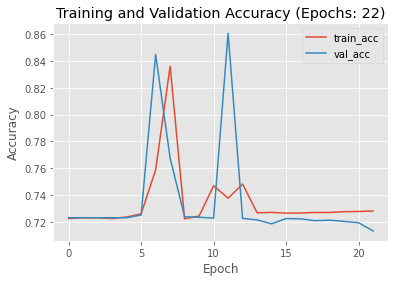

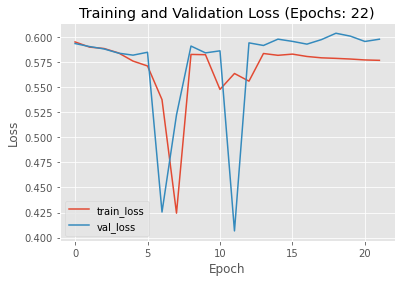

CPU times: user 1h 9min 44s, sys: 2min 26s, total: 1h 12min 11s
Wall time: 42min 45s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="RNNModel")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 2

Model: "RNNModel2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          467840    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               65792     
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 566,657
Trainable params: 566,657
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1606/1606 [==============================] - 219s 135ms/step - loss: 0.6076 - accuracy: 0.7148 - val_loss

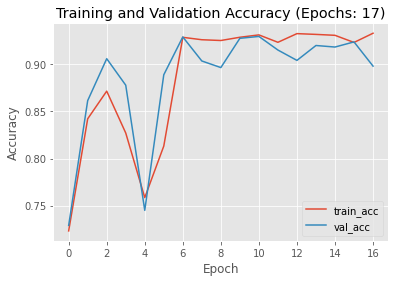

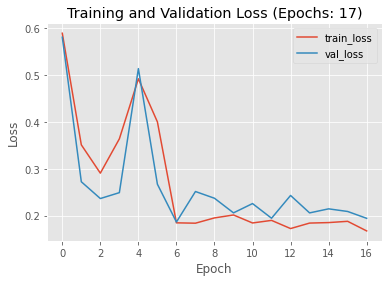

CPU times: user 1h 46min 48s, sys: 3min 11s, total: 1h 50min
Wall time: 1h 1min 19s


In [ ]:
%%time

model = Sequential(name="RNNModel2")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

# Bi-Directionals:

model.add(Bidirectional(SimpleRNN(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 3

Epoch 1/100
1606/1606 [==============================] - 309s 191ms/step - loss: 0.3787 - accuracy: 0.8452 - val_loss: 0.2155 - val_accuracy: 0.9344
Epoch 2/100
1606/1606 [==============================] - 293s 183ms/step - loss: 0.1673 - accuracy: 0.9483 - val_loss: 0.3960 - val_accuracy: 0.8537
Epoch 3/100
1606/1606 [==============================] - 288s 180ms/step - loss: 0.2231 - accuracy: 0.9251 - val_loss: 0.3101 - val_accuracy: 0.9168
Epoch 4/100
1606/1606 [==============================] - 287s 179ms/step - loss: 0.1897 - accuracy: 0.9376 - val_loss: 0.2055 - val_accuracy: 0.9440
Epoch 5/100
1606/1606 [==============================] - 293s 182ms/step - loss: 0.1790 - accuracy: 0.9438 - val_loss: 0.2000 - val_accuracy: 0.9444
Epoch 6/100
1606/1606 [==============================] - 302s 188ms/step - loss: 0.1747 - accuracy: 0.9509 - val_loss: 0.1760 - val_accuracy: 0.9506
Epoch 7/100
1606/1606 [==============================] - 304s 189ms/step - loss: 0.1582 - accuracy: 0.9526

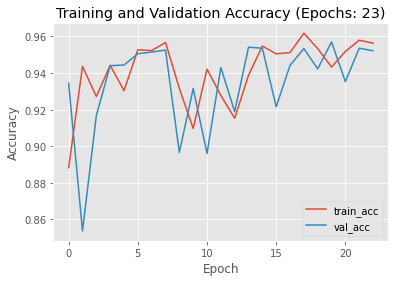

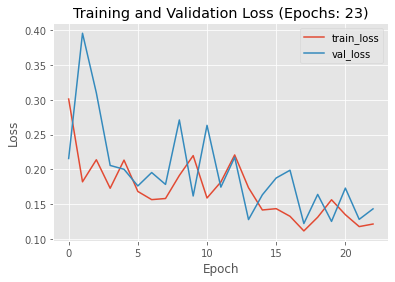

CPU times: user 3h 19min 41s, sys: 6min 43s, total: 3h 26min 24s
Wall time: 1h 53min 15s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="RNNModel3")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))
model.add(Bidirectional(SimpleRNN(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 4

Epoch 1/100
1606/1606 [==============================] - 221s 137ms/step - loss: 0.6053 - accuracy: 0.7195 - val_loss: 0.5921 - val_accuracy: 0.7233
Epoch 2/100
1606/1606 [==============================] - 221s 138ms/step - loss: 0.5945 - accuracy: 0.7216 - val_loss: 0.5906 - val_accuracy: 0.7233
Epoch 3/100
1606/1606 [==============================] - 222s 138ms/step - loss: 0.5918 - accuracy: 0.7228 - val_loss: 0.5914 - val_accuracy: 0.7233
Epoch 4/100
1606/1606 [==============================] - 220s 137ms/step - loss: 0.5913 - accuracy: 0.7221 - val_loss: 0.5898 - val_accuracy: 0.7233
Epoch 5/100
1606/1606 [==============================] - 223s 139ms/step - loss: 0.5905 - accuracy: 0.7229 - val_loss: 0.5900 - val_accuracy: 0.7233
Epoch 6/100
1606/1606 [==============================] - 223s 139ms/step - loss: 0.5933 - accuracy: 0.7212 - val_loss: 0.5920 - val_accuracy: 0.7233
Epoch 7/100
1606/1606 [==============================] - 224s 140ms/step - loss: 0.5907 - accuracy: 0.7201

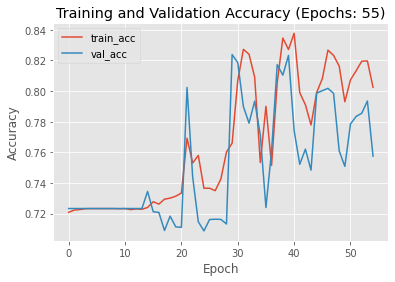

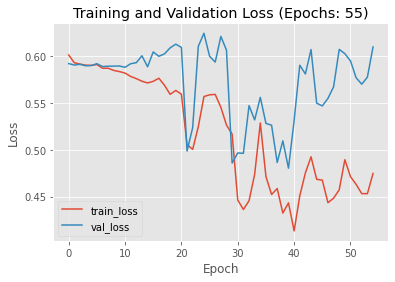

CPU times: user 5h 52min 8s, sys: 11min 46s, total: 6h 3min 54s
Wall time: 3h 27min 22s


In [ ]:
%%time

model = Sequential(name="GruModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))
model.add(SimpleRNN(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 5

Epoch 1/100
1606/1606 [==============================] - 251s 154ms/step - loss: 0.6028 - accuracy: 0.7178 - val_loss: 0.5020 - val_accuracy: 0.7919
Epoch 2/100
1606/1606 [==============================] - 244s 152ms/step - loss: 0.5146 - accuracy: 0.7611 - val_loss: 0.5686 - val_accuracy: 0.7267
Epoch 3/100
1606/1606 [==============================] - 244s 152ms/step - loss: 0.5639 - accuracy: 0.7252 - val_loss: 0.4065 - val_accuracy: 0.8390
Epoch 4/100
1606/1606 [==============================] - 244s 152ms/step - loss: 0.3690 - accuracy: 0.8443 - val_loss: 1.0790 - val_accuracy: 0.4539
Epoch 5/100
1606/1606 [==============================] - 247s 154ms/step - loss: 0.4072 - accuracy: 0.8177 - val_loss: 0.2301 - val_accuracy: 0.9245
Epoch 6/100
1606/1606 [==============================] - 244s 152ms/step - loss: 0.2907 - accuracy: 0.8897 - val_loss: 0.1974 - val_accuracy: 0.9408
Epoch 7/100
1606/1606 [==============================] - 246s 153ms/step - loss: 0.3251 - accuracy: 0.8721

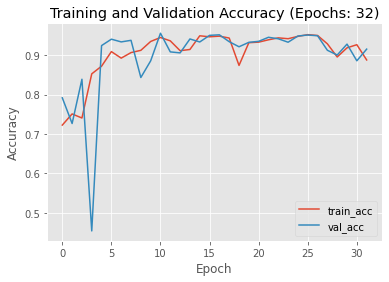

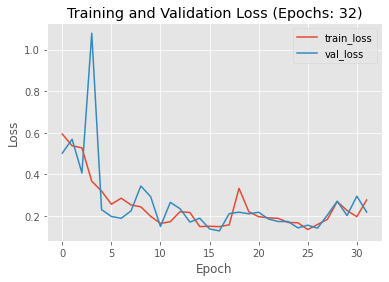

CPU times: user 3h 52min 12s, sys: 7min 16s, total: 3h 59min 29s
Wall time: 2h 9min 53s


In [ ]:
%%time

model = Sequential(name="GruModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(64, return_sequences=True))
model.add(SimpleRNN(64, return_sequences=True, recurrent_dropout=0.5))
model.add(Bidirectional(SimpleRNN(64, dropout=0.5)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## 9 Conclusiones

Reporta tus conclusiones.

---

Se intentaron varios modelos con diferentes arquitecturas para tratar de encontrar la mejor arquitectura con resultados similares en el dataset de validación y en el de prueba pero cuyas gráficas de accuracy y loss muestran diferentes panoramas.

Para todos los modelos se usó un EarlyStopping que después de un determinado periodo de paciencia reestableciera los mejores pesos encontrados. Esto es algo que tener en mente ya que algunas de las gráficas muestran el inicio de un sobre-entrenamiento, pero esto no quiere decir que se usaron los pesos sobre-entrenados para predecir en el dataset de validación, sino que se usaron los pesos encontrados en el momento justo antes de que el sobre-entrenamiento comenzara a aperecer.

## RNN
1. Tamaño vocabulario: 3655 (palabras que aparecen al menos 50 veces)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 150
1. Tamaño de embedding: 3655/128 (entrada/salida)
1. Optimizer: Adam

RNN | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
Modelo1|0.86|4321.95
Modelo2|0.93|6582.50
Modelo3|0.95|12357.37
Modelo4|0.82|21815.96
Modelo5|0.95|14350.99


En todos los modelos se aprecia un rápido sobre-entrenamiento pero gracias al `EarlyStopping` configurado se puede obtener el último modelo antes que el problema comience a agravarse, lo que permite conseguir el mejor.

En estas pruebas el mejor modelo es el 3 ya que tuvo el mejor accuracy con la arquitectura menos compleja que requirió menos tiempo de entrenamiento.

# Parte IV: Modelo GRU

## 10

Repite la Parte III pero ahora tomando como base el bloque GRU. 


### Modelo 1

Epoch 1/100
1606/1606 [==============================] - 259s 160ms/step - loss: 0.5100 - accuracy: 0.7707 - val_loss: 0.0994 - val_accuracy: 0.9641
Epoch 2/100
1606/1606 [==============================] - 253s 158ms/step - loss: 0.0810 - accuracy: 0.9679 - val_loss: 0.0846 - val_accuracy: 0.9618
Epoch 3/100
1606/1606 [==============================] - 253s 158ms/step - loss: 0.0625 - accuracy: 0.9748 - val_loss: 0.1676 - val_accuracy: 0.9230
Epoch 4/100
1606/1606 [==============================] - 254s 158ms/step - loss: 0.0487 - accuracy: 0.9808 - val_loss: 0.1760 - val_accuracy: 0.9319
Epoch 5/100
1606/1606 [==============================] - 253s 157ms/step - loss: 0.0367 - accuracy: 0.9861 - val_loss: 0.2079 - val_accuracy: 0.9274
Epoch 6/100
1606/1606 [==============================] - 258s 161ms/step - loss: 0.0307 - accuracy: 0.9889 - val_loss: 0.3456 - val_accuracy: 0.8649
Epoch 7/100
1606/1606 [==============================] - 258s 161ms/step - loss: 0.0496 - accuracy: 0.9814

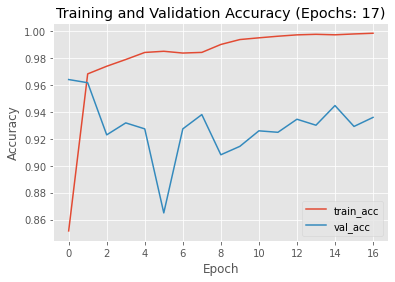

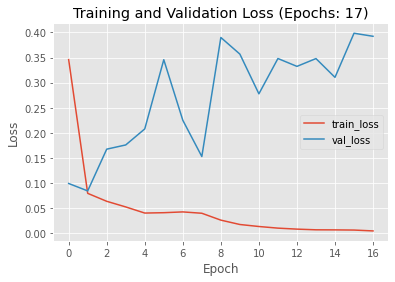

CPU times: user 2h 9min 24s, sys: 3min 20s, total: 2h 12min 44s
Wall time: 1h 13min 7s


In [ ]:
%%time

model = Sequential(name="GruModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(GRU(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 2

Epoch 1/100
1606/1606 [==============================] - 486s 300ms/step - loss: 0.2124 - accuracy: 0.9143 - val_loss: 0.0875 - val_accuracy: 0.9648
Epoch 2/100
1606/1606 [==============================] - 470s 293ms/step - loss: 0.0744 - accuracy: 0.9710 - val_loss: 0.0824 - val_accuracy: 0.9672
Epoch 3/100
1606/1606 [==============================] - 466s 290ms/step - loss: 0.0592 - accuracy: 0.9761 - val_loss: 0.0966 - val_accuracy: 0.9600
Epoch 4/100
1606/1606 [==============================] - 467s 291ms/step - loss: 0.0465 - accuracy: 0.9820 - val_loss: 0.0965 - val_accuracy: 0.9629
Epoch 5/100
1606/1606 [==============================] - 467s 291ms/step - loss: 0.0346 - accuracy: 0.9864 - val_loss: 0.1209 - val_accuracy: 0.9617
Epoch 6/100
1606/1606 [==============================] - 469s 292ms/step - loss: 0.0236 - accuracy: 0.9909 - val_loss: 0.1487 - val_accuracy: 0.9564
Epoch 7/100
1606/1606 [==============================] - 468s 292ms/step - loss: 0.0164 - accuracy: 0.9940

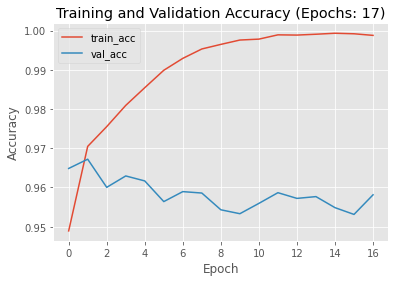

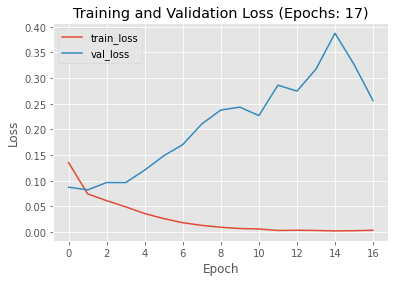

CPU times: user 4h 5min 44s, sys: 5min 36s, total: 4h 11min 20s
Wall time: 2h 13min 21s


In [ ]:
%%time

model = Sequential(name="GruModel2")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(GRU(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 3

Epoch 1/100
1606/1606 [==============================] - 728s 450ms/step - loss: 0.2234 - accuracy: 0.9101 - val_loss: 0.0857 - val_accuracy: 0.9654
Epoch 2/100
1606/1606 [==============================] - 705s 439ms/step - loss: 0.0714 - accuracy: 0.9726 - val_loss: 0.0813 - val_accuracy: 0.9674
Epoch 3/100
1606/1606 [==============================] - 706s 440ms/step - loss: 0.0629 - accuracy: 0.9763 - val_loss: 0.0946 - val_accuracy: 0.9606
Epoch 4/100
1606/1606 [==============================] - 703s 438ms/step - loss: 0.0497 - accuracy: 0.9808 - val_loss: 0.1005 - val_accuracy: 0.9608
Epoch 5/100
1606/1606 [==============================] - 703s 438ms/step - loss: 0.0443 - accuracy: 0.9837 - val_loss: 0.1065 - val_accuracy: 0.9648
Epoch 6/100
1606/1606 [==============================] - 703s 438ms/step - loss: 0.0298 - accuracy: 0.9891 - val_loss: 0.1343 - val_accuracy: 0.9533
Epoch 7/100
1606/1606 [==============================] - 707s 440ms/step - loss: 0.0227 - accuracy: 0.9915

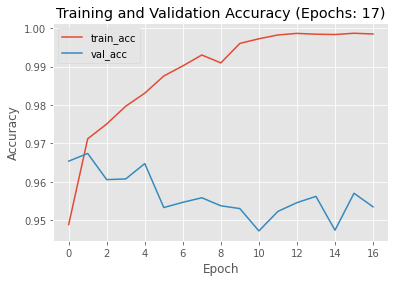

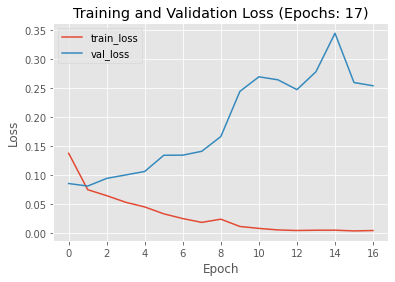

CPU times: user 6h 10min 38s, sys: 8min 33s, total: 6h 19min 11s
Wall time: 3h 21min 18s


In [ ]:
%%time

model = Sequential(name="GruModel3")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(GRU(128, return_sequences=True))

model.add(Bidirectional(GRU(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 4

Epoch 1/100
1606/1606 [==============================] - 509s 315ms/step - loss: 0.4843 - accuracy: 0.7833 - val_loss: 0.0887 - val_accuracy: 0.9636
Epoch 2/100
1606/1606 [==============================] - 494s 308ms/step - loss: 0.0813 - accuracy: 0.9676 - val_loss: 0.0861 - val_accuracy: 0.9651
Epoch 3/100
1606/1606 [==============================] - 486s 303ms/step - loss: 0.0620 - accuracy: 0.9748 - val_loss: 0.1092 - val_accuracy: 0.9588
Epoch 4/100
1606/1606 [==============================] - 488s 304ms/step - loss: 0.0482 - accuracy: 0.9806 - val_loss: 0.2374 - val_accuracy: 0.9281
Epoch 5/100
1606/1606 [==============================] - 489s 305ms/step - loss: 0.0379 - accuracy: 0.9859 - val_loss: 0.1980 - val_accuracy: 0.9391
Epoch 6/100
1606/1606 [==============================] - 490s 305ms/step - loss: 0.0301 - accuracy: 0.9889 - val_loss: 0.2947 - val_accuracy: 0.9465
Epoch 7/100
1606/1606 [==============================] - 492s 307ms/step - loss: 0.0215 - accuracy: 0.9912

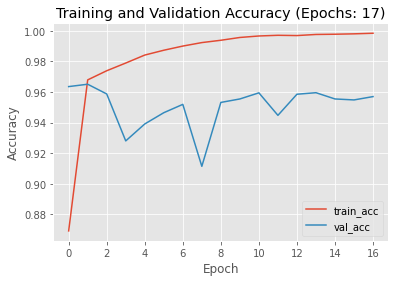

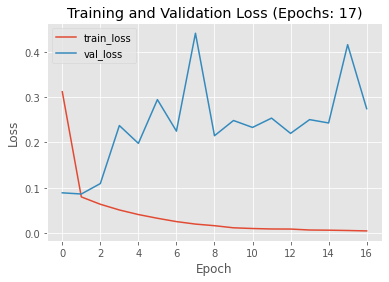

CPU times: user 4h 12min 59s, sys: 5min 7s, total: 4h 18min 7s
Wall time: 2h 19min 55s


In [ ]:
%%time

model = Sequential(name="GruModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(GRU(128, return_sequences=True))
model.add(GRU(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 5

Epoch 1/100
1606/1606 [==============================] - 876s 540ms/step - loss: 0.2608 - accuracy: 0.8964 - val_loss: 0.0989 - val_accuracy: 0.9591
Epoch 2/100
1606/1606 [==============================] - 863s 538ms/step - loss: 0.0875 - accuracy: 0.9659 - val_loss: 0.0832 - val_accuracy: 0.9673
Epoch 3/100
1606/1606 [==============================] - 864s 538ms/step - loss: 0.0726 - accuracy: 0.9702 - val_loss: 0.0809 - val_accuracy: 0.9658
Epoch 4/100
1606/1606 [==============================] - 864s 538ms/step - loss: 0.0684 - accuracy: 0.9719 - val_loss: 0.0895 - val_accuracy: 0.9670
Epoch 5/100
1606/1606 [==============================] - 862s 537ms/step - loss: 0.0617 - accuracy: 0.9767 - val_loss: 0.0840 - val_accuracy: 0.9676
Epoch 6/100
1606/1606 [==============================] - 863s 537ms/step - loss: 0.0591 - accuracy: 0.9767 - val_loss: 0.0894 - val_accuracy: 0.9651
Epoch 7/100
1606/1606 [==============================] - 858s 534ms/step - loss: 0.0543 - accuracy: 0.9791

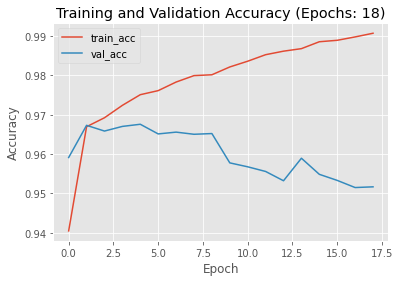

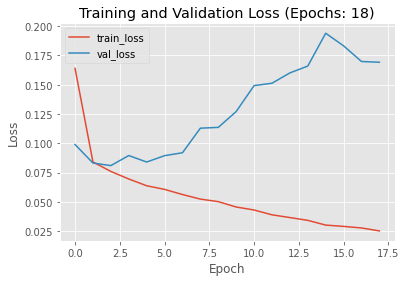

CPU times: user 7h 41min 35s, sys: 23min 22s, total: 8h 4min 57s
Wall time: 4h 19min 11s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="GruModel5")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(GRU(64, return_sequences=True, recurrent_dropout=0.5, dropout=0.5))
model.add(GRU(64, return_sequences=True, recurrent_dropout=0.5, dropout=0.5))
model.add(Bidirectional(GRU(64, dropout=0.5)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

---

1. Tamaño vocabulario: 3655 (palabras que aparecen al menos 50 veces)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 150
1. Tamaño de embedding: 3655/128 (entrada/salida)
1. Optimizer: Adam

GRU | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
Modelo1|0.96|7943.55
Modelo2|0.97|15041.73
Modelo3|0.97|22692.59
Modelo4|0.97|15445.42
Modelo5|0.97|29054.59

En general en todos los modelos se aprecian mejore resultados que con RNN.

En todos los modelos se aprecia un rápido sobre-entrenamiento pero gracias al `EarlyStopping` configurado se puede obtener el último modelo antes que el problema comience a agravarse, lo que permite conseguir el mejor.

Se aplica dropout de 0.5 para el kernel y para el output recurrente sin que se aprecien beneficios evidentes, de hecho, se incrementa el tiempo de entrenamiento.

En estas pruebas el mejor modelo es el 2 ya que tuvo el mejor accuracy con la arquitectura menos compleja, sólo se requirió de una capa GRU Bidireccional.


# Parte V: Modelo LSTM
## 11

Repite la Parte III pero ahora tomando como base el bloque LSTM.

## Modelo 1

Epoch 1/100
1606/1606 [==============================] - 292s 181ms/step - loss: 0.5789 - accuracy: 0.7325 - val_loss: 0.3068 - val_accuracy: 0.8919
Epoch 2/100
1606/1606 [==============================] - 291s 181ms/step - loss: 0.3510 - accuracy: 0.8663 - val_loss: 0.1386 - val_accuracy: 0.9506
Epoch 3/100
1606/1606 [==============================] - 290s 181ms/step - loss: 0.1154 - accuracy: 0.9595 - val_loss: 0.0898 - val_accuracy: 0.9655
Epoch 4/100
1606/1606 [==============================] - 291s 181ms/step - loss: 0.0702 - accuracy: 0.9743 - val_loss: 0.0924 - val_accuracy: 0.9623
Epoch 5/100
1606/1606 [==============================] - 291s 181ms/step - loss: 0.0595 - accuracy: 0.9772 - val_loss: 0.3353 - val_accuracy: 0.9090
Epoch 6/100
1606/1606 [==============================] - 291s 181ms/step - loss: 0.0477 - accuracy: 0.9809 - val_loss: 0.4229 - val_accuracy: 0.8790
Epoch 7/100
1606/1606 [==============================] - 290s 181ms/step - loss: 0.0382 - accuracy: 0.9856

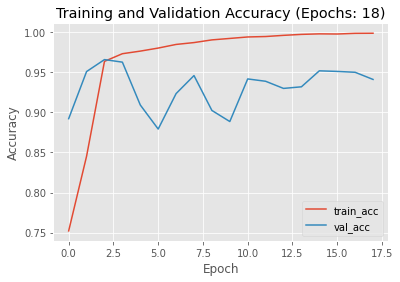

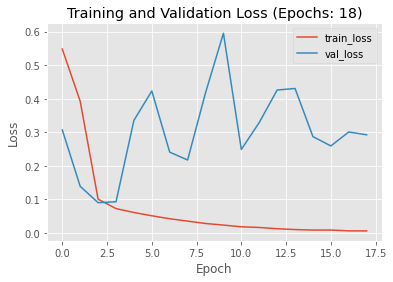

CPU times: user 2h 31min 28s, sys: 4min 23s, total: 2h 35min 52s
Wall time: 1h 27min 39s


In [ ]:
%%time

model = Sequential(name="LstmModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 2

Epoch 1/100
1606/1606 [==============================] - 584s 361ms/step - loss: 0.2175 - accuracy: 0.9123 - val_loss: 0.1138 - val_accuracy: 0.9559
Epoch 2/100
1606/1606 [==============================] - 576s 358ms/step - loss: 0.0841 - accuracy: 0.9684 - val_loss: 0.0997 - val_accuracy: 0.9612
Epoch 3/100
1606/1606 [==============================] - 601s 374ms/step - loss: 0.0659 - accuracy: 0.9739 - val_loss: 0.1070 - val_accuracy: 0.9486
Epoch 4/100
1606/1606 [==============================] - 626s 390ms/step - loss: 0.0575 - accuracy: 0.9779 - val_loss: 0.0973 - val_accuracy: 0.9633
Epoch 5/100
1606/1606 [==============================] - 623s 388ms/step - loss: 0.0426 - accuracy: 0.9833 - val_loss: 0.1213 - val_accuracy: 0.9526
Epoch 6/100
1606/1606 [==============================] - 623s 388ms/step - loss: 0.0343 - accuracy: 0.9868 - val_loss: 0.1465 - val_accuracy: 0.9540
Epoch 7/100
1606/1606 [==============================] - 623s 388ms/step - loss: 0.0274 - accuracy: 0.9903

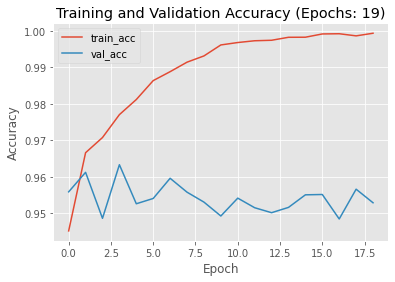

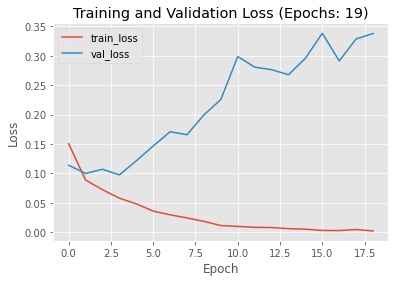

CPU times: user 5h 56min 2s, sys: 8min 47s, total: 6h 4min 50s
Wall time: 3h 13min 38s


In [ ]:
%%time

model = Sequential(name="LTSMModel2")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 3

Epoch 1/100
1606/1606 [==============================] - 951s 588ms/step - loss: 0.2172 - accuracy: 0.9151 - val_loss: 0.0944 - val_accuracy: 0.9649
Epoch 2/100
1606/1606 [==============================] - 920s 573ms/step - loss: 0.0854 - accuracy: 0.9674 - val_loss: 0.0878 - val_accuracy: 0.9628
Epoch 3/100
1606/1606 [==============================] - 924s 575ms/step - loss: 0.0738 - accuracy: 0.9723 - val_loss: 0.0912 - val_accuracy: 0.9656
Epoch 4/100
1606/1606 [==============================] - 930s 579ms/step - loss: 0.0636 - accuracy: 0.9751 - val_loss: 0.1336 - val_accuracy: 0.9524
Epoch 5/100
1606/1606 [==============================] - 927s 577ms/step - loss: 0.0495 - accuracy: 0.9808 - val_loss: 0.1066 - val_accuracy: 0.9623
Epoch 6/100
1606/1606 [==============================] - 917s 571ms/step - loss: 0.0432 - accuracy: 0.9828 - val_loss: 0.1265 - val_accuracy: 0.9628
Epoch 7/100
1606/1606 [==============================] - 915s 570ms/step - loss: 0.0349 - accuracy: 0.9872

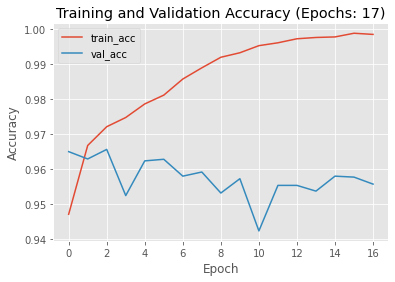

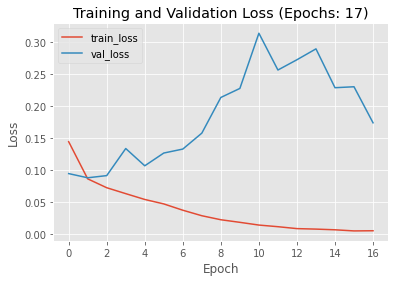

CPU times: user 8h 6min 26s, sys: 11min 16s, total: 8h 17min 43s
Wall time: 4h 22min 57s


In [ ]:
%%time

model = Sequential(name="LSTMModel3")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(128, return_sequences=True))

model.add(Bidirectional(LSTM(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 4

Epoch 1/100
1606/1606 [==============================] - 639s 396ms/step - loss: 0.5774 - accuracy: 0.7243 - val_loss: 0.5482 - val_accuracy: 0.7233
Epoch 2/100
1606/1606 [==============================] - 628s 391ms/step - loss: 0.5423 - accuracy: 0.7260 - val_loss: 0.5856 - val_accuracy: 0.7233
Epoch 3/100
1606/1606 [==============================] - 628s 391ms/step - loss: 0.5316 - accuracy: 0.7672 - val_loss: 0.2179 - val_accuracy: 0.9445
Epoch 4/100
1606/1606 [==============================] - 629s 392ms/step - loss: 0.1539 - accuracy: 0.9542 - val_loss: 0.0939 - val_accuracy: 0.9636
Epoch 5/100
1606/1606 [==============================] - 626s 390ms/step - loss: 0.0754 - accuracy: 0.9699 - val_loss: 0.0943 - val_accuracy: 0.9598
Epoch 6/100
1606/1606 [==============================] - 623s 388ms/step - loss: 0.0650 - accuracy: 0.9739 - val_loss: 0.0940 - val_accuracy: 0.9586
Epoch 7/100
1606/1606 [==============================] - 626s 390ms/step - loss: 0.0560 - accuracy: 0.9772

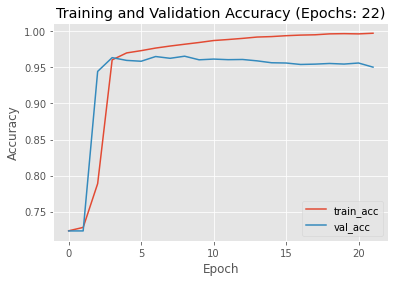

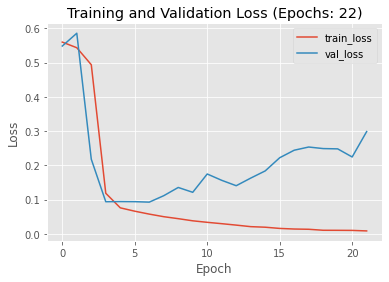

CPU times: user 6h 56min 32s, sys: 9min 56s, total: 7h 6min 28s
Wall time: 3h 51min 2s


In [ ]:
%%time

model = Sequential(name="LTSMModel4")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 5

Epoch 1/100
1606/1606 [==============================] - 986s 608ms/step - loss: 0.2392 - accuracy: 0.9037 - val_loss: 0.0931 - val_accuracy: 0.9635
Epoch 2/100
1606/1606 [==============================] - 961s 598ms/step - loss: 0.0952 - accuracy: 0.9629 - val_loss: 0.0950 - val_accuracy: 0.9621
Epoch 3/100
1606/1606 [==============================] - 974s 606ms/step - loss: 0.0762 - accuracy: 0.9702 - val_loss: 0.0915 - val_accuracy: 0.9631
Epoch 4/100
1606/1606 [==============================] - 969s 603ms/step - loss: 0.0696 - accuracy: 0.9717 - val_loss: 0.1311 - val_accuracy: 0.9500
Epoch 5/100
1606/1606 [==============================] - 968s 603ms/step - loss: 0.0637 - accuracy: 0.9745 - val_loss: 0.1031 - val_accuracy: 0.9591
Epoch 6/100
1606/1606 [==============================] - 965s 601ms/step - loss: 0.0593 - accuracy: 0.9771 - val_loss: 0.0891 - val_accuracy: 0.9657
Epoch 7/100
1606/1606 [==============================] - 967s 602ms/step - loss: 0.0589 - accuracy: 0.9770

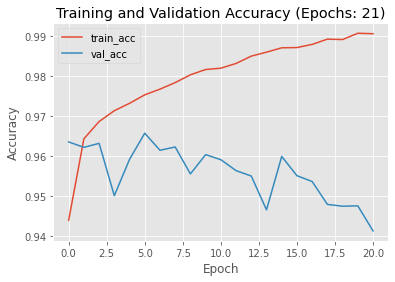

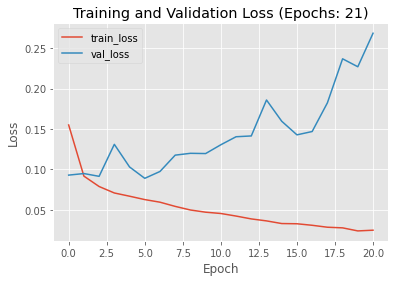

CPU times: user 10h 8min 13s, sys: 32min 38s, total: 10h 40min 52s
Wall time: 5h 42min 13s


In [ ]:
%%time

model = Sequential(name="LTSMModel5")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.5, dropout=0.5))
model.add(LSTM(64, return_sequences=True, recurrent_dropout=0.5, dropout=0.5))
model.add(Bidirectional(LSTM(64, dropout=0.5)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=15,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

1. Tamaño vocabulario: 3655 (palabras que aparecen al menos 50 veces)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 150
1. Tamaño de embedding: 3655/128 (entrada/salida) 3655/64 en Modelo 5
1. Optimizer: Adam

LSTM | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
Modelo1|0.97|9327.11
Modelo2|0.96|21840.40
Modelo3|0.96|29782.67
Modelo4|0.97|25530.84
Modelo5|0.97|38400.09

En general en todos los modelos se aprecian mejore resultados que con RNN, pero tiempos de entrenamiento mayores que GRU

En todos los modelos se aprecia un rápido sobre-entrenamiento pero gracias al `EarlyStopping` configurado se puede obtener el último modelo antes que el problema comience a agravarse, lo que permite conseguir el mejor.

Se aplica dropout de 0.5 para el kernel y para el output recurrente  así como una reducción en la dimensión y en el número de neuronas a 64, sin que se aprecien beneficios evidentes, de hecho, se incrementa el tiempo de entrenamiento.

En estas pruebas el mejor modelo es el 1 ya que tuvo el mejor accuracy con la arquitectura menos compleja que requirió menos tiempo de entrenamiento, sólo se requirió de una capa LSTM.

# Parte VI: Análisis con Body y excluyendo stopwords

## 12

Repite las Partes I a V, pero excluyendo ahora el conjunto de palabras stopwords. Puedes modificar el conjunto de stopwords si lo deseas, incluyendo o excluyendo palabras que consideres ayudarán a mejorar el modelo. Por ejemplo, deberás determinar si al menos las palabras relacionadas con negaciones las incluyes o no en el análisis. Reporta tus conclusiones de cada etapa y compáralo con los resultados obtenidos con los stopwords.

---

Para esta parte se quitarán usarán los mejores y más simples modelos encontrados para RNN, GRU y LSTM.

Para la limpieza del texto se limitará a mantener sólo aquellos tokens de al menos 2 caracteres. Se preservarán también las palabras negativas en el texto.

## Preparación de datos

### Listado de stopwords

In [ ]:
print(f"Stopwords list length: {len(my_stopwords)}")

Stopwords list length: 139


### Limpieza de Body avanzada

In [ ]:
train_data_5, val_data_5, test_data_5 = clean_up_column(train_data,
                                                        val_data,
                                                        test_data,
                                                        column_to_clean = "Body",
                                                        stop_words = my_stopwords,
                                                        token_min_length = 2)



*********
* Train *
*********


,Body
0,set android 442 drop mobile data connection da...
1,way prevent messages app sending long texts ge...
2,john doe texts group includes me appears notif...
3,going installed applications phone ago clear j...
4,sony xperia settings button dropbox top right ...




*******
* Val *
*******


,Body
0,decided delete iphones photos copied everythin...
1,possible downgrade kitkat someone please tell ...
2,droid installed 1password like take passwords ...
3,android app enables handwriting drawing word d...
4,whenever new profile applied small gray round ...




********
* Test *
********


,Body
0,networks charges high cellular dataso disabili...
1,lg android bought sd card would always end ins...
2,way upload voice memos recording google drive ...
3,im using cydia impactor wish copy ipa file pc ...
4,im trying move application install sd card nex...


### Tokenización



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 71098


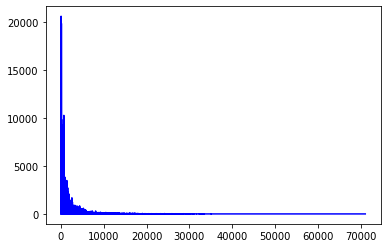



****************************************************************
* My vocabulary reduced to words that happen at least 50 times *
****************************************************************
New vocabulary size reduced to words happening at least 50 times: 3634
Represents a reduction of 94.8887451123801% 



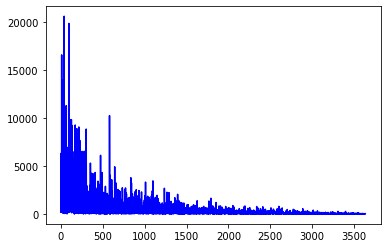



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 3634 (compared to 3634 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 running lollipop 511 currently theory 8gb internal memory however cant seem track exactly happened space 100 apps including system installed phone starts reporting space move apps external microsd card problem even custom rom installation recent rom update well factory issue nearly months now periodically ive internet suggestions clues without making real progress seems large space phones memory simply unused possible whats going on ive included output command terminal emulator below notice seem duplicates internal memory though think one other reported size data storage reports used accessible files used files adds clai

In [ ]:
train_sequences, validation_sequences, test_sequences = get_token_sequences(train_data_5,
                                                                            val_data_5,
                                                                            test_data_5,
                                                                            column_to_process = "Body",
                                                                            min_freq = 50)

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_5.iloc[1988]['Body']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {val_data_5.iloc[1988]['Body']}\n {validation_sequences[1988]}")

### Vectorización

Midamos el número apropiado de padding basado en las métricas de los documentos

In [ ]:
calculate_document_length_metrics(train_data_5,
                                  val_data_5,
                                  column = "Body")



*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 0
Max length: 863
Mean length: 46.80656024917267
Std Dev of length: 37.846426232995995


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 3
Max length: 831
Mean length: 50.73310319767442
Std Dev of length: 41.35294800201997


Dadas las longitudes promedio y las desviaciones estándar, lo apropiado sería poner el padding a alrededor de 85.

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 85

train_padded = pad_sequences(train_sequences,
                            maxlen = max_len_vector,
                            padding = padding_type,
                            truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                        maxlen = max_len_vector,
                        padding = padding_type,
                        truncating = padding_type)


print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")

print_marquee("Sample of a record with no body")
print(f"Padded: {train_padded[25310]}")



************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [20, 25, 438, 556, 2020, 16, 499, 436, 219, 39, 615, 70, 2, 10, 400, 453, 153, 678, 434, 789, 1621, 5, 139, 286, 346, 415, 723, 144, 61, 536, 3101, 239, 84, 3413, 436, 9, 11, 146, 961, 694, 701, 11, 277, 1707, 174, 104, 2928, 2, 26, 400, 3294, 28, 9, 779, 28, 917] 

 Padded:
 [20, 25, 438, 556, 2020, 16, 499, 436, 219, 39, 615, 70, 2, 10, 400, 453, 153, 678, 434, 789, 1621, 5, 139, 286, 346, 415, 723, 144, 61, 536, 3101, 239, 84, 3413, 436, 9, 11, 146, 961, 694, 701, 11, 277, 1707, 174, 104, 2928, 2, 26, 400, 3294, 28, 9, 779, 28, 917, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


***********************************
* Sample of a record with no body *
***********************************
Padded: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### Preparación final de dataset

In [ ]:
# Let's first prepare the final datasets in the form that will be used for training

train_final = train_data_5.copy()
X_train = train_padded
y_train = train_final["LabelNum"].to_numpy()

val_final = val_data_5.copy()
X_val = val_padded
y_val = val_final["LabelNum"].to_numpy()

test_final = test_data_5.copy()
X_test = pad_sequences(validation_sequences,
                       maxlen = max_len_vector,
                       padding = padding_type,
                       truncating = padding_type)
y_test = test_final["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")
print(f"Test final shape: X: {X_test.shape}, y: {y_test.shape}")

# Let's see the distribution of the classes
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

print(f"Percentage of positive classes in Test: {(sum(y_test)/len(y_test)) * 100} %")

batch_size = 32

Train final shape X: (51370, 85), y: (51370,)
Val final shape: X: (11008, 85), y: (11008,)
Test final shape: X: (11008, 85), y: (11008,)
Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %
Percentage of positive classes in Test: 27.679869186046513 %


## RNN

Epoch 1/100
1606/1606 [==============================] - 157s 96ms/step - loss: 0.2912 - accuracy: 0.8819 - val_loss: 0.2641 - val_accuracy: 0.8733
Epoch 2/100
1606/1606 [==============================] - 156s 97ms/step - loss: 0.2080 - accuracy: 0.9236 - val_loss: 0.1662 - val_accuracy: 0.9410
Epoch 3/100
1606/1606 [==============================] - 156s 97ms/step - loss: 0.2179 - accuracy: 0.9134 - val_loss: 0.2510 - val_accuracy: 0.9063
Epoch 4/100
1606/1606 [==============================] - 155s 97ms/step - loss: 0.2762 - accuracy: 0.8891 - val_loss: 0.2304 - val_accuracy: 0.9125
Epoch 5/100
1606/1606 [==============================] - 156s 97ms/step - loss: 0.1761 - accuracy: 0.9388 - val_loss: 0.2709 - val_accuracy: 0.8824
Epoch 6/100
1606/1606 [==============================] - 156s 97ms/step - loss: 0.1706 - accuracy: 0.9344 - val_loss: 0.1957 - val_accuracy: 0.9231
Epoch 7/100
1606/1606 [==============================] - 155s 97ms/step - loss: 0.1368 - accuracy: 0.9476 - val_

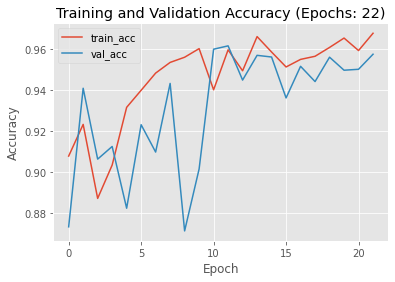

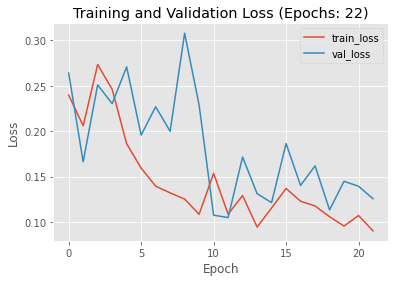

CPU times: user 1h 40min 4s, sys: 3min 2s, total: 1h 43min 7s
Wall time: 57min 13s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="RNNModelAdvanced")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(128, return_sequences=True))
model.add(Bidirectional(SimpleRNN(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## GRU

Epoch 1/100
1606/1606 [==============================] - 303s 187ms/step - loss: 0.1821 - accuracy: 0.9227 - val_loss: 0.0795 - val_accuracy: 0.9683
Epoch 2/100
1606/1606 [==============================] - 288s 179ms/step - loss: 0.0649 - accuracy: 0.9750 - val_loss: 0.0787 - val_accuracy: 0.9685
Epoch 3/100
1606/1606 [==============================] - 287s 179ms/step - loss: 0.0508 - accuracy: 0.9804 - val_loss: 0.0837 - val_accuracy: 0.9675
Epoch 4/100
1606/1606 [==============================] - 286s 178ms/step - loss: 0.0356 - accuracy: 0.9863 - val_loss: 0.0971 - val_accuracy: 0.9637
Epoch 5/100
1606/1606 [==============================] - 286s 178ms/step - loss: 0.0237 - accuracy: 0.9908 - val_loss: 0.1302 - val_accuracy: 0.9632
Epoch 6/100
1606/1606 [==============================] - 286s 178ms/step - loss: 0.0173 - accuracy: 0.9933 - val_loss: 0.1696 - val_accuracy: 0.9592
Epoch 7/100
1606/1606 [==============================] - 299s 186ms/step - loss: 0.0093 - accuracy: 0.9965

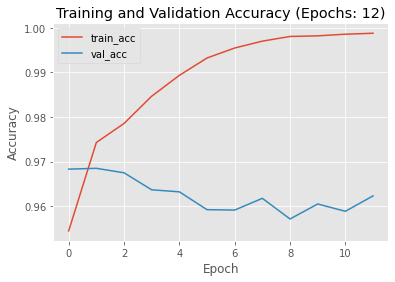

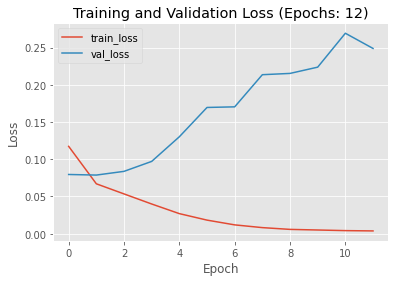

CPU times: user 1h 46min 4s, sys: 2min 33s, total: 1h 48min 38s
Wall time: 59min 5s


In [ ]:
%%time

model = Sequential(name="GruModelAdvanced")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(GRU(128)))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

batch_size = 32

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## LSTM

Epoch 1/100
1606/1606 [==============================] - 175s 108ms/step - loss: 0.4982 - accuracy: 0.7643 - val_loss: 0.2885 - val_accuracy: 0.9027
Epoch 2/100
1606/1606 [==============================] - 173s 108ms/step - loss: 0.1775 - accuracy: 0.9483 - val_loss: 0.0864 - val_accuracy: 0.9658
Epoch 3/100
1606/1606 [==============================] - 174s 108ms/step - loss: 0.0725 - accuracy: 0.9721 - val_loss: 0.0834 - val_accuracy: 0.9687
Epoch 4/100
1606/1606 [==============================] - 174s 108ms/step - loss: 0.0558 - accuracy: 0.9776 - val_loss: 0.0911 - val_accuracy: 0.9657
Epoch 5/100
1606/1606 [==============================] - 175s 109ms/step - loss: 0.0418 - accuracy: 0.9837 - val_loss: 0.0966 - val_accuracy: 0.9649
Epoch 6/100
1606/1606 [==============================] - 175s 109ms/step - loss: 0.0312 - accuracy: 0.9885 - val_loss: 0.1003 - val_accuracy: 0.9631
Epoch 7/100
1606/1606 [==============================] - 175s 109ms/step - loss: 0.0192 - accuracy: 0.9934

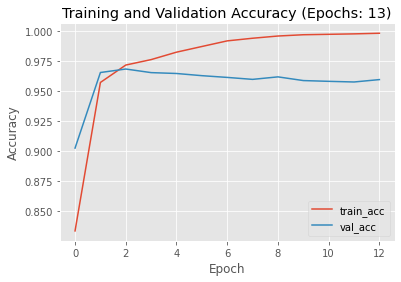

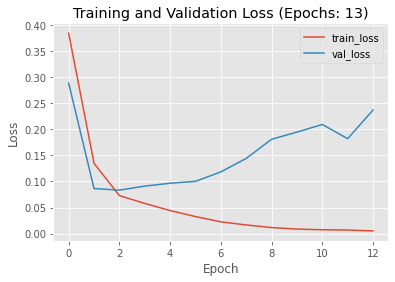

CPU times: user 1h 5min 30s, sys: 2min 3s, total: 1h 7min 33s
Wall time: 37min 57s


In [ ]:
%%time

model = Sequential(name="LstmModel1")

# embeddidng layer
model.add(Embedding(input_dim=len(my_vocab),
                    output_dim = 128,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(128))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

1. Tamaño vocabulario: 3634 (palabras que aparecen al menos 50 veces)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 85
1. Tamaño de embedding: 3634/128 (entrada/salida)
1. Se mantienen sólo tokens de al menos 2 caracteres
1. Se eliminan stopwords pero se preservan palabras negativas en el texto.
1. Longitud de lista de stopwords: 139
1. Optimizer: Adam

Modelo | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
RNN|0.96|6173.57
GRU|0.97|6494.80
LSTM|0.97|4038.03

Se observan mejores resultados con una mejora evidente con RNN, lo que parece indicar que al reducir el vocabulario a aquellas palabras que aportan más información tiene un efecto positivo en el accuracy.

En RNN se aprecia muchos brincos en la medición de accuracy y de loss, pero se mantiene consistente y con un una varianza relativamente pequeña.

En GRU se aprecia un rápido sobre-entrenamiento que fue rápidamente capturado por el Early Stopping. LSTM posee una gráfica más consistente y sin tantos brincos pero con bastante varianza.

En estas pruebas el mejor modelo es LSTM ya que tuvo el mejor accuracy y el menor tiempo de entrenamiento, una de las cosas a considerar en los siguientes modelos es aplicar regularización para reducir el efecto de brincos en el proceso de entrenamiento.

# Parte VII: Análisis con Title

## 13

Repite las Partes I a V, pero usando ahora solamente los enunciados de la columna Title y la columna con las etiquetas de las mismas. Deberás decidir y justificar si incluyes o no stopwords. Reporta tus resultados de cada etapa.

---

Se removerán los stopwords del title pero dejando las palabras negativas intactas, esto nos permitirá extraer la mayor cantidad de información relevante de los Title que de por sí ya tiene una longitud muy pequeña.

## Preparacion de datos

### Limpieza de Title avanzada

In [ ]:
train_data_7, val_data_7, test_data_7 = clean_up_column(train_data,
                                                        val_data,
                                                        test_data,
                                                        column_to_clean = "Title",
                                                        stop_words = my_stopwords,
                                                        token_min_length = 2)



*********
* Train *
*********


,Title
0,dropstop mobile data connection nonwifi condit...
1,automatically crop text messages sms character...
2,cant find text message group
3,cant store contacts android phone
4,dropbox samsung galaxy settings button




*******
* Val *
*******


,Title
0,erase iphone photos completely
1,downgrade lg flex
2,make 1password android log built browser
3,handwrite draw text document
4,turn applying profile profile applied notifica...




********
* Test *
********


,Title
0,disable usage background data apps
1,low space android
2,voice memos ios app recording google drive
3,transfer ipa file iphone
4,cant move applications sd card couldnt move ap...


### Tokenización

Dado que el corpus de `Title` posee menos palabras en su vocabulario, se reducirá la mínima frecuencia necesaria para que una palabra sea considerada en el vocabulario final para evitar tener demasiados registros donde el title termine con una secuencia vacía (por no tener ninguna palabra que ocurra al menos este número de veces).



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 17957


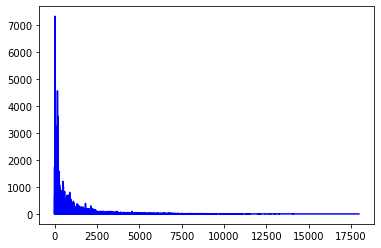



***************************************************************
* My vocabulary reduced to words that happen at least 5 times *
***************************************************************
New vocabulary size reduced to words happening at least 5 times: 4400
Represents a reduction of 75.49702066046667% 



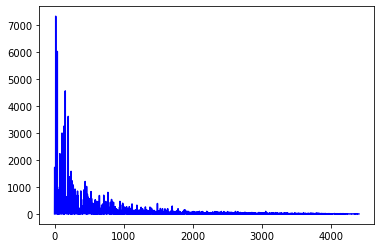



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 4400 (compared to 4400 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 missing space internal storage
 [203, 134, 105, 44]


**************************************************
* Validation sample of document vs. its encoding *
**************************************************
The document and its encoding:
 restart launcher apart restarting phone
 [545, 376, 1, 779, 5]


In [ ]:
# Remove those records that don't have anything in their title
train_sequences, validation_sequences, test_sequences = get_token_sequences(train_data_7,
                                                                            val_data_7,
                                                                            test_data_7,
                                                                            column_to_process = "Title",
                                                                            min_freq = 5)
# Calculate all of the unique values in the training dataset + 1 to account for the OOV token
my_vocab_size_7 = len(set(chain(*train_sequences))) + 1

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_7.iloc[1988]['Title']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {val_data_7.iloc[1988]['Title']}\n {validation_sequences[1988]}")

### Vectorización

Debemos ver qué número de vectores será el más adecuado para nuestro dataset primero.

In [ ]:
calculate_document_length_metrics(train_data_7,
                                  val_data_7,
                                  column = "Title")



*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 1
Max length: 20
Mean length: 6.074343001751996
Std Dev of length: 2.1875729395851553


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 1
Max length: 18
Mean length: 6.047874273255814
Std Dev of length: 2.167212130386971


Dadas estas métricas se optará por un valor de 6 para el un padding posterior.

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 6

train_padded = pad_sequences(train_sequences,
                             maxlen = max_len_vector,
                             padding = padding_type,
                             truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                           maxlen = max_len_vector,
                           padding = padding_type,
                           truncating = padding_type)


print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")

print_marquee("Sample of a record with no title")
print(f"Padded: {train_padded[1306]}")



************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [191, 2, 5, 14, 339] 

 Padded:
 [191, 2, 5, 14, 339, 0]


************************************
* Sample of a record with no title *
************************************
Padded: [0 0 0 0 0 0]


### Preparación final del dataset

In [ ]:
# Let's first prepare the final datasets in the form that will be used for training

train_final = train_data_7.copy()
X_train = train_padded
y_train = train_final["LabelNum"].to_numpy()

val_final = val_data_7.copy()
X_val = val_padded
y_val = val_final["LabelNum"].to_numpy()

test_final = test_data_7.copy()
X_test = pad_sequences(validation_sequences,
                       maxlen = max_len_vector,
                       padding = padding_type,
                       truncating = padding_type)
y_test = test_final["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")
print(f"Test final shape: X: {X_test.shape}, y: {y_test.shape}")

# Let's see the distribution of the classes
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

print(f"Percentage of positive classes in Test: {(sum(y_test)/len(y_test)) * 100} %")

Train final shape X: (51370, 6), y: (51370,)
Val final shape: X: (11008, 6), y: (11008,)
Test final shape: X: (11008, 6), y: (11008,)
Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %
Percentage of positive classes in Test: 27.679869186046513 %


## RNN

Epoch 1/100
1606/1606 [==============================] - 39s 23ms/step - loss: 3.0302 - accuracy: 0.8933 - val_loss: 0.2068 - val_accuracy: 0.9390
Epoch 2/100
1606/1606 [==============================] - 35s 22ms/step - loss: 0.1878 - accuracy: 0.9466 - val_loss: 0.2023 - val_accuracy: 0.9392
Epoch 3/100
1606/1606 [==============================] - 37s 23ms/step - loss: 0.1737 - accuracy: 0.9508 - val_loss: 0.1999 - val_accuracy: 0.9380
Epoch 4/100
1606/1606 [==============================] - 36s 22ms/step - loss: 0.1663 - accuracy: 0.9522 - val_loss: 0.2110 - val_accuracy: 0.9384
Epoch 5/100
1606/1606 [==============================] - 35s 22ms/step - loss: 0.1627 - accuracy: 0.9520 - val_loss: 0.2078 - val_accuracy: 0.9381
Epoch 6/100
1606/1606 [==============================] - 34s 21ms/step - loss: 0.1510 - accuracy: 0.9553 - val_loss: 0.2047 - val_accuracy: 0.9369
Epoch 7/100
1606/1606 [==============================] - 36s 22ms/step - loss: 0.1531 - accuracy: 0.9555 - val_loss: 0

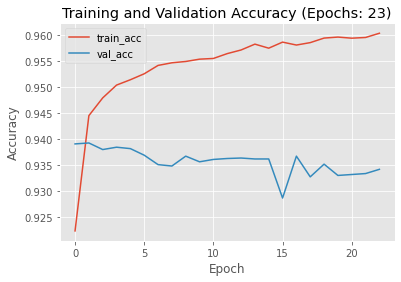

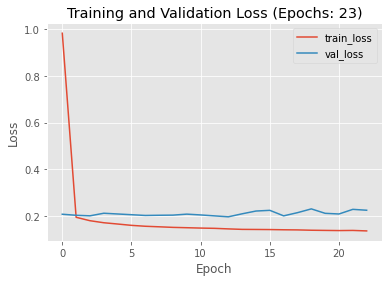

CPU times: user 18min 17s, sys: 1min 56s, total: 20min 14s
Wall time: 13min 56s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="RNNModelTitle")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_7,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(64,
                    return_sequences=True,
                    kernel_regularizer="l1_l2"))
model.add(Bidirectional(SimpleRNN(64,
                                  kernel_regularizer="l1_l2")))

# Dense layers
model.add(Dense(64, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## GRU

Epoch 1/100
1606/1606 [==============================] - 46s 10ms/step - loss: 5.1410 - accuracy: 0.8265 - val_loss: 0.2737 - val_accuracy: 0.9351
Epoch 2/100
1606/1606 [==============================] - 17s 11ms/step - loss: 0.2450 - accuracy: 0.9450 - val_loss: 0.2755 - val_accuracy: 0.9233
Epoch 3/100
1606/1606 [==============================] - 17s 11ms/step - loss: 0.2230 - accuracy: 0.9503 - val_loss: 0.2545 - val_accuracy: 0.9350
Epoch 4/100
1606/1606 [==============================] - 18s 11ms/step - loss: 0.2141 - accuracy: 0.9512 - val_loss: 0.2553 - val_accuracy: 0.9355
Epoch 5/100
1606/1606 [==============================] - 17s 10ms/step - loss: 0.2041 - accuracy: 0.9539 - val_loss: 0.2629 - val_accuracy: 0.9374
Epoch 6/100
1606/1606 [==============================] - 16s 10ms/step - loss: 0.2039 - accuracy: 0.9533 - val_loss: 0.2545 - val_accuracy: 0.9363
Epoch 7/100
1606/1606 [==============================] - 16s 10ms/step - loss: 0.1993 - accuracy: 0.9545 - val_loss: 0

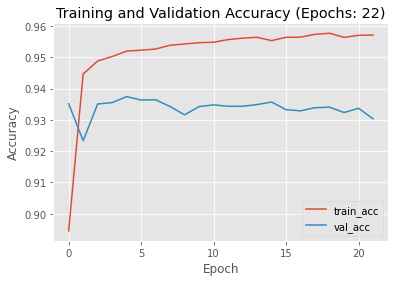

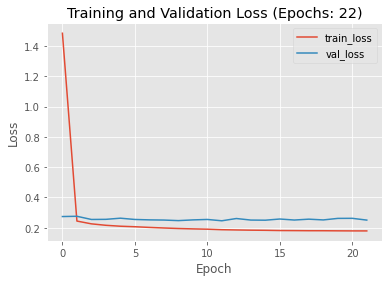

CPU times: user 7min 57s, sys: 56.2 s, total: 8min 53s
Wall time: 6min 38s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="GruModelTitle")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_7,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(GRU(64,
                            recurrent_regularizer="l1_l2",
                            kernel_regularizer="l1_l2")))

# Dense layers
model.add(Dense(64, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## LSTM

Epoch 1/100
1606/1606 [==============================] - 21s 11ms/step - loss: 2.8386 - accuracy: 0.8749 - val_loss: 0.2164 - val_accuracy: 0.9378
Epoch 2/100
1606/1606 [==============================] - 16s 10ms/step - loss: 0.1973 - accuracy: 0.9460 - val_loss: 0.2233 - val_accuracy: 0.9295
Epoch 3/100
1606/1606 [==============================] - 16s 10ms/step - loss: 0.1794 - accuracy: 0.9510 - val_loss: 0.2175 - val_accuracy: 0.9342
Epoch 4/100
1606/1606 [==============================] - 15s 10ms/step - loss: 0.1724 - accuracy: 0.9534 - val_loss: 0.2092 - val_accuracy: 0.9386
Epoch 5/100
1606/1606 [==============================] - 15s 9ms/step - loss: 0.1674 - accuracy: 0.9555 - val_loss: 0.2147 - val_accuracy: 0.9389
Epoch 6/100
1606/1606 [==============================] - 15s 9ms/step - loss: 0.1662 - accuracy: 0.9562 - val_loss: 0.2129 - val_accuracy: 0.9391
Epoch 7/100
1606/1606 [==============================] - 14s 9ms/step - loss: 0.1635 - accuracy: 0.9571 - val_loss: 0.22

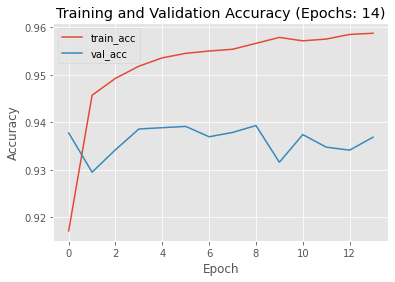

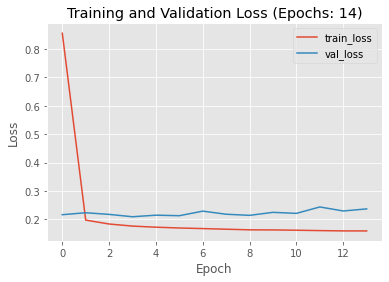

CPU times: user 4min 32s, sys: 26.8 s, total: 4min 58s
Wall time: 3min 33s


In [ ]:
%%time

model = Sequential(name="LstmModelTitle")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_7,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               kernel_regularizer="l1_l2"))
model.add(LSTM(64))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

1. Tamaño vocabulario: 4400 (5 palabras más comunes)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 6
1. Tamaño de embedding: 4400/64 (entrada/salida)
1. Se mantienen sólo tokens de al menos 2 caracteres
1. Se eliminan stopwords pero se preservan palabras negativas en el texto.
1. Longitud de lista de stopwords: 139
1. Regularizador: L1L2 en Kernel y en algunos casos en Recurrente
1. Optimizer: Adam

Modelo | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
RNN|0.94|1211.65
GRU|0.93|531.26
LSTM|0.94|296.60

Se ven resultados un tanto peores a usar todo el Body, lo cual es entendible ya que la cantidad de información en el Title es menor. Se tuvo que reducir el número de apariciones de una palabra para que sea considerada en el vocabulario a 5.

Se usó regularización y se observan menos brincos en la medición de accuracy y de loss en comparación con los modelos anteriores, pero se observa una varianza pronunciada sobre todo en accuracy. En el loss se observa menos varianza.

LSTM logró un mejor accuracy en menos tiempo de entrenamiento por lo cual se concluye que éste es el mejor modelo para este problema en particular.

# Parte VIII: Análisis con Title y Body

## 14

Repite las Partes I a V, pero conjuntando la información de las columnas Title y Body. Deberás decidir y justificar si incluyes o no stopwords. Reporta tus resultados de cada etapa.

## Preparación de datos

Para esta sección se creará una nueva columna que concatene los valores de Title y de Body y posteriormente se hará un tratamiento similar al de los anteriores incisos.

### Creación de nueva columna TitleBody

In [ ]:
train_data_8 = train_data.copy()
val_data_8 = val_data.copy()
test_data_8 = test_data.copy()

train_data_8["TitleBody"] = train_data_8["Title"] + " " + train_data_8["Body"]
val_data_8["TitleBody"] = val_data_8["Title"] + " " + val_data_8["Body"]
test_data_8["TitleBody"] = test_data_8["Title"] + " " + test_data_8["Body"]

print_marquee("Train")
display(train_data_8.head(5))

print_marquee("Val")
display(val_data_8.head(5))

print_marquee("Test")
display(test_data_8.head(5))



*********
* Train *
*********


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,197234,Drop\stop mobile data connection (non-wifi) by...,<p>Can I set Android 4.4.2 to drop mobile data...,0,34,android,0,Drop\stop mobile data connection (non-wifi) by...
1,114800,How to automatically crop text messages when S...,<p>Is there a way to prevent the Messages app ...,0,836,android,0,How to automatically crop text messages when S...
2,124532,Can't find text message that was to a group,<p>When John Doe texts to a group that include...,1,28,android,0,Can't find text message that was to a group <p...
3,193875,Can't store contacts on my Android phone,<p>I was going through all of my installed app...,0,158,android,0,Can't store contacts on my Android phone <p>I ...
4,50332,Dropbox on Samsung Galaxy - where is the Setti...,"<p>On a Sony Xperia, the settings button in Dr...",1,963,android,0,Dropbox on Samsung Galaxy - where is the Setti...




*******
* Val *
*******


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,282570,How to erase my iPhone photos completely?,<p>I decided to delete all of my iPhone's phot...,1,95,ios,1,How to erase my iPhone photos completely? <p>I...
1,151903,How can i Downgrade my Lg G Flex 2?,<p>Is it possible for me to downgrade to kitka...,0,695,android,0,How can i Downgrade my Lg G Flex 2? <p>Is it p...
2,16128,How can I make 1Password for Android log in wi...,<p>I have a Droid X and have just installed 1P...,1,586,android,0,How can I make 1Password for Android log in wi...
3,33177,Handwrite / draw on a text document,<p>Is there an Android app that enables hand-w...,0,7340,android,0,Handwrite / draw on a text document <p>Is ther...
4,65171,"How to turn off ""applying profile"" and ""profil...",<p>Whenever a new profile is applied there is ...,0,519,android,0,"How to turn off ""applying profile"" and ""profil..."




********
* Test *
********


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,202290,How to disable usage of background data of all...,<p>Some networks charges high in cellular data...,1,5785,android,0,How to disable usage of background data of all...
1,151626,Low space On my Android,<p>I have a LG android and I bought a sd card ...,1,130,android,0,Low space On my Android <p>I have a LG android...
2,129401,Voice Memos (ios app) recording to Google Drive,<p>Is there any way to upload the Voice Memos ...,2,36111,ios,1,Voice Memos (ios app) recording to Google Driv...
3,332306,Transfer IPA file to iPhone,<p>I'm using Cydia Impactor and wish to copy a...,0,478,ios,1,Transfer IPA file to iPhone <p>I'm using Cydia...
4,34587,"Can't move any applications to SD Card- ""Could...",<p>I'm trying to move any application that I i...,3,3895,android,0,"Can't move any applications to SD Card- ""Could..."


### Limpieza de TitleBody

Se eliminarán stopwords pero se mantendrán las palabras negativas y sólo se preservarán tokens que tengan al menos 2 caracteres.

In [ ]:
train_data_8, val_data_8, test_data_8 = clean_up_column(train_data_8,
                                                        val_data_8,
                                                        test_data_8,
                                                        column_to_clean = "TitleBody",
                                                        stop_words = my_stopwords,
                                                        token_min_length = 2,
                                                        create_data_copy = False)



*********
* Train *
*********


,TitleBody
0,dropstop mobile data connection nonwifi condit...
1,automatically crop text messages sms character...
2,cant find text message group john doe texts gr...
3,cant store contacts android phone going instal...
4,dropbox samsung galaxy settings button sony xp...




*******
* Val *
*******


,TitleBody
0,erase iphone photos completely decided delete ...
1,downgrade lg flex possible downgrade kitkat so...
2,make 1password android log built browser droid...
3,handwrite draw text document android app enabl...
4,turn applying profile profile applied notifica...




********
* Test *
********


,TitleBody
0,disable usage background data apps networks ch...
1,low space android lg android bought sd card wo...
2,voice memos ios app recording google drive way...
3,transfer ipa file iphone im using cydia impact...
4,cant move applications sd card couldnt move ap...


### Tokenización



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 74195


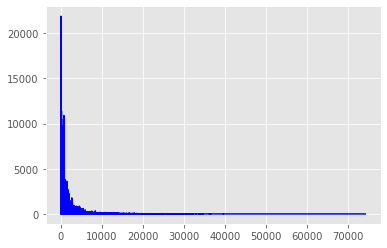



****************************************************************
* My vocabulary reduced to words that happen at least 50 times *
****************************************************************
New vocabulary size reduced to words happening at least 50 times: 3764
Represents a reduction of 94.9268818653548% 



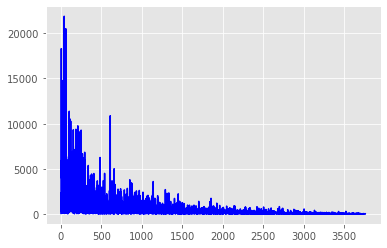



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 3764 (compared to 3764 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 missing space internal storage gti9195 running lollipop 511 currently pacrom theory 8gb internal memory however cant seem track exactly happened space paltry 100 apps including system essentials installed phone starts reporting space move apps external microsd card problem persisted even custom rom installation subsequent recent rom update well factory resetscache wipesetc issue nearly months now periodically ive trawled internet suggestions clues without making real progress seems large chunk space phones memory simply inaccessible unused possible delve deeper whats going on ive included output df command terminal emula

In [ ]:
# Remove those records that don't have anything in their title
train_sequences, validation_sequences, test_sequences = get_token_sequences(train_data_8,
                                                                            val_data_8,
                                                                            test_data_8,
                                                                            column_to_process = "TitleBody",
                                                                            min_freq = 50)
# Calculate all of the unique values in the training dataset + 1 to account for the OOV token
my_vocab_size_8 = len(set(chain(*train_sequences))) + 1

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_8.iloc[1988]['TitleBody']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {val_data_8.iloc[1988]['TitleBody']}\n {validation_sequences[1988]}")

### Vectorización

Como lo hemos venido haciendo, debemos sacar las métricas para un óptimo padding

In [ ]:
calculate_document_length_metrics(train_data_8,
                                  val_data_8,
                                  column = "TitleBody")



*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 4
Max length: 1611
Mean length: 57.70846797741873
Std Dev of length: 43.59530440123147


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 6
Max length: 838
Mean length: 56.780341569767444
Std Dev of length: 41.75179079629431


Dadas estas métricas, un valor óptimo para un padding posterior sería 100

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 100

train_padded = pad_sequences(train_sequences,
                             maxlen = max_len_vector,
                             padding = padding_type,
                             truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                           maxlen = max_len_vector,
                           padding = padding_type,
                           truncating = padding_type)


print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")



************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [383, 4, 2, 24, 429, 22, 27, 383, 544, 2044, 11, 531, 429, 232, 44, 484, 86, 2, 9, 404, 492, 155, 672, 456, 766, 1530, 4, 140, 326, 331, 382, 726, 126, 57, 510, 3146, 197, 92, 3579, 429, 8, 14, 161, 1010, 738, 719, 14, 236, 1576, 167, 91, 2979, 2, 24, 404, 3092, 33, 8, 850, 33, 844] 

 Padded:
 [383, 4, 2, 24, 429, 22, 27, 383, 544, 2044, 11, 531, 429, 232, 44, 484, 86, 2, 9, 404, 492, 155, 672, 456, 766, 1530, 4, 140, 326, 331, 382, 726, 126, 57, 510, 3146, 197, 92, 3579, 429, 8, 14, 161, 1010, 738, 719, 14, 236, 1576, 167, 91, 2979, 2, 24, 404, 3092, 33, 8, 850, 33, 844, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Preparación final del dataset

In [ ]:
# Let's first prepare the final datasets in the form that will be used for training
X_train = train_padded
y_train = train_final["LabelNum"].to_numpy()

X_val = val_padded
y_val = val_final["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")

# Let's see the distribution of the classes
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

Train final shape X: (51370, 100), y: (51370,)
Val final shape: X: (11008, 100), y: (11008,)
Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %


## RNN

Epoch 1/100
1606/1606 [==============================] - 339s 210ms/step - loss: 1.2001 - accuracy: 0.9289 - val_loss: 0.2600 - val_accuracy: 0.9473
Epoch 2/100
1606/1606 [==============================] - 332s 207ms/step - loss: 0.1363 - accuracy: 0.9755 - val_loss: 0.1606 - val_accuracy: 0.9747
Epoch 3/100
1606/1606 [==============================] - 334s 208ms/step - loss: 0.1176 - accuracy: 0.9799 - val_loss: 0.1336 - val_accuracy: 0.9764
Epoch 4/100
1606/1606 [==============================] - 343s 213ms/step - loss: 0.1299 - accuracy: 0.9768 - val_loss: 0.1304 - val_accuracy: 0.9590
Epoch 5/100
1606/1606 [==============================] - 341s 212ms/step - loss: 0.0810 - accuracy: 0.9814 - val_loss: 0.0940 - val_accuracy: 0.9732
Epoch 6/100
1606/1606 [==============================] - 337s 210ms/step - loss: 0.0943 - accuracy: 0.9796 - val_loss: 0.0974 - val_accuracy: 0.9749
Epoch 7/100
1606/1606 [==============================] - 334s 208ms/step - loss: 0.0739 - accuracy: 0.9840

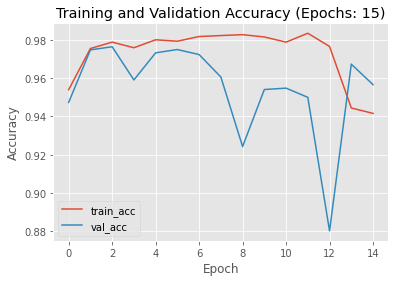

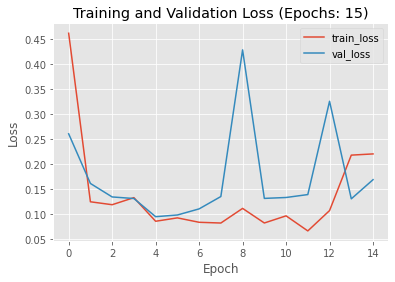

CPU times: user 2h 8min 6s, sys: 13min 41s, total: 2h 21min 48s
Wall time: 1h 23min 39s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="RNNModelTitleBody")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_8,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(SimpleRNN(64,
                    return_sequences=True,
                    kernel_regularizer="l1_l2"))
model.add(Bidirectional(SimpleRNN(64)))

# Dense layers
model.add(Dense(64, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## GRU

Epoch 1/100
1606/1606 [==============================] - 30s 17ms/step - loss: 5.0884 - accuracy: 0.8501 - val_loss: 0.1746 - val_accuracy: 0.9773
Epoch 2/100
1606/1606 [==============================] - 25s 15ms/step - loss: 0.1555 - accuracy: 0.9835 - val_loss: 0.1643 - val_accuracy: 0.9770
Epoch 3/100
1606/1606 [==============================] - 25s 15ms/step - loss: 0.1384 - accuracy: 0.9863 - val_loss: 0.1575 - val_accuracy: 0.9778
Epoch 4/100
1606/1606 [==============================] - 25s 15ms/step - loss: 0.1279 - accuracy: 0.9894 - val_loss: 0.1615 - val_accuracy: 0.9775
Epoch 5/100
1606/1606 [==============================] - 25s 16ms/step - loss: 0.1219 - accuracy: 0.9903 - val_loss: 0.1484 - val_accuracy: 0.9770
Epoch 6/100
1606/1606 [==============================] - 25s 15ms/step - loss: 0.1120 - accuracy: 0.9916 - val_loss: 0.1561 - val_accuracy: 0.9772
Epoch 7/100
1606/1606 [==============================] - 25s 15ms/step - loss: 0.1130 - accuracy: 0.9914 - val_loss: 0

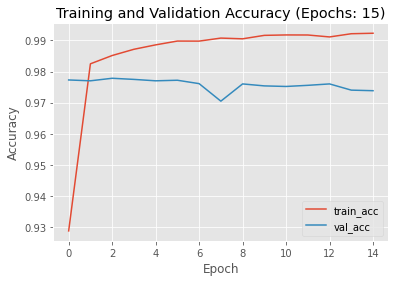

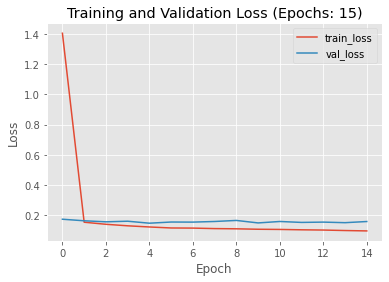

CPU times: user 7min 10s, sys: 41 s, total: 7min 51s
Wall time: 6min 25s


In [ ]:
%%time

batch_size = 32

model = Sequential(name="GruModelTitleBody")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_8,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(GRU(64,
                            recurrent_regularizer="l1_l2",
                            kernel_regularizer="l1_l2")))

# Dense layers
model.add(Dense(64, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## LSTM

Epoch 1/100
1606/1606 [==============================] - 32s 18ms/step - loss: 1.4451 - accuracy: 0.7880 - val_loss: 0.2873 - val_accuracy: 0.9108
Epoch 2/100
1606/1606 [==============================] - 28s 17ms/step - loss: 0.2911 - accuracy: 0.9122 - val_loss: 0.2370 - val_accuracy: 0.9226
Epoch 3/100
1606/1606 [==============================] - 29s 18ms/step - loss: 0.2078 - accuracy: 0.9442 - val_loss: 1.0087 - val_accuracy: 0.7237
Epoch 4/100
1606/1606 [==============================] - 29s 18ms/step - loss: 0.5734 - accuracy: 0.7790 - val_loss: 0.1270 - val_accuracy: 0.9713
Epoch 5/100
1606/1606 [==============================] - 28s 17ms/step - loss: 0.1079 - accuracy: 0.9746 - val_loss: 0.0742 - val_accuracy: 0.9811
Epoch 6/100
1606/1606 [==============================] - 28s 18ms/step - loss: 0.0652 - accuracy: 0.9841 - val_loss: 0.0747 - val_accuracy: 0.9798
Epoch 7/100
1606/1606 [==============================] - 28s 18ms/step - loss: 0.0493 - accuracy: 0.9890 - val_loss: 0

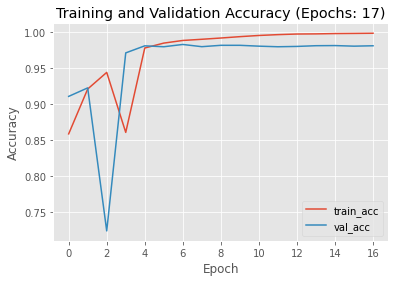

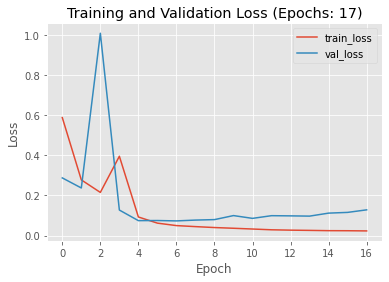

CPU times: user 7min 55s, sys: 39.3 s, total: 8min 34s
Wall time: 8min 6s


In [ ]:
%%time

model = Sequential(name="LstmModelTitleBody")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_8,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               #kernel_regularizer="l1_l2"
               ))
model.add(LSTM(64))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = None,
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

1. Tamaño vocabulario: 3764 (50 palabras más comunes)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 100
1. Tamaño de embedding: 3764/64 (entrada/salida)
1. Se mantienen sólo tokens de al menos 2 caracteres
1. Se eliminan stopwords pero se preservan palabras negativas en el texto.
1. Longitud de lista de stopwords: 139
1. Regularizador: L1L2 en Kernel y en algunos casos en Recurrente
1. Optimizer: Adam

Modelo | Accuracy (val) | Tiempo entrenamiento (seg)
:---|:---:|:---:
RNN|0.97|8500.58
GRU|0.98|468.23
LSTM|0.98|511.06

Se observan mejores resultados con todos los modelos, lo cual indica que el agregar el título aporta información valiosa que parece traducirse en 1% más de accuracy.

Se usó regularización en todos los modelos y eso parece aliviar los brincos que dan las gráficas, aunque no los elimina por completo. La varianza en RNN se mantiene reducida, en algunos epochs, pero no en todos, en GRU se mantiene una varianza más pronunciada y en LSTM se obtiene una gráfica con una varianza bastante reducida.

Dados los resultados y las gráficas, el mejor modelo es LSTM ya que tiene el mejor accuracy y sus gráficas muestran una varianza mínima que se traduce en mejores F1-Scores y por ende menos elementos clasificados incorrectamente.

# Parte IX: Modelo final
## 15

Con base a los resultados anteriores determina cuál sería tu mejor modelo: incluyendo el análisis del procesamiento de los documentos y tokenización inicial, si consideras que debieras usar las columnas Body y/o Title y la arquitectura de la red neuronal profunda usada. Incluye los ajustes adicionales que consideres mejoren tu modelo final. Realiza un diagrama de flujo que  muestre la metodología final. Aplica dicho modelo al conjunto de prueba y reporta tus resultados finales.

NOTA: esta es la única vez que usarás el conjunto de prueba.

---

Para este modelo se utilizará las técnicas de limpieza usadas en parte VIII: se creará una nueva columna que concatene Title y Body, y se usará la mejor arquitectura encontrada que fue con LSTM y se usará regularización en los output recurrentes, se limitará a sólo los tokens que tengan al menos 2 caracteres. A diferencia de los anteriores modelos, se usará stemming.

Finalmente se harán experimentos con Dropout y con regularización para verificar si esto ayuda más al proceso o no.

## Método

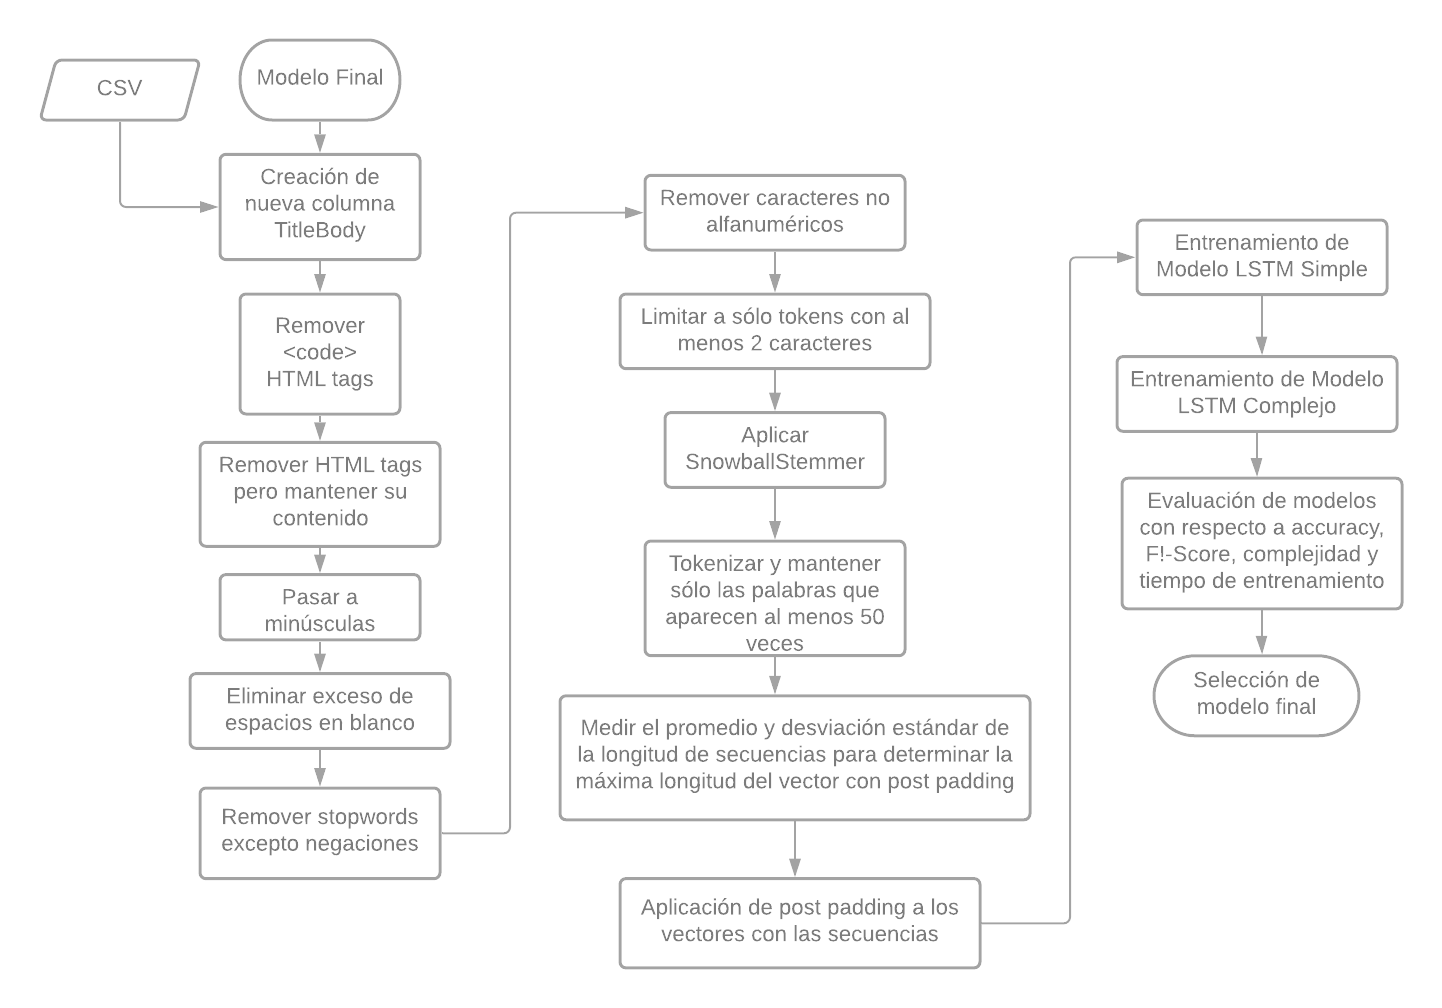

## Preparación de datos

### Creación de nueva columna TitleBody

In [ ]:
train_data_9 = train_data.copy()
val_data_9 = val_data.copy()
test_data_9 = test_data.copy()

train_data_9["TitleBody"] = train_data_9["Title"] + " " + train_data_9["Body"]
val_data_9["TitleBody"] = val_data_9["Title"] + " " + val_data_9["Body"]
test_data_9["TitleBody"] = test_data_9["Title"] + " " + test_data_9["Body"]

print_marquee("Train")
display(train_data_9.head(5))

print_marquee("Val")
display(val_data_9.head(5))

print_marquee("Test")
display(test_data_9.head(5))



*********
* Train *
*********


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,197234,Drop\stop mobile data connection (non-wifi) by...,<p>Can I set Android 4.4.2 to drop mobile data...,0,34,android,0,Drop\stop mobile data connection (non-wifi) by...
1,114800,How to automatically crop text messages when S...,<p>Is there a way to prevent the Messages app ...,0,836,android,0,How to automatically crop text messages when S...
2,124532,Can't find text message that was to a group,<p>When John Doe texts to a group that include...,1,28,android,0,Can't find text message that was to a group <p...
3,193875,Can't store contacts on my Android phone,<p>I was going through all of my installed app...,0,158,android,0,Can't store contacts on my Android phone <p>I ...
4,50332,Dropbox on Samsung Galaxy - where is the Setti...,"<p>On a Sony Xperia, the settings button in Dr...",1,963,android,0,Dropbox on Samsung Galaxy - where is the Setti...




*******
* Val *
*******


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,282570,How to erase my iPhone photos completely?,<p>I decided to delete all of my iPhone's phot...,1,95,ios,1,How to erase my iPhone photos completely? <p>I...
1,151903,How can i Downgrade my Lg G Flex 2?,<p>Is it possible for me to downgrade to kitka...,0,695,android,0,How can i Downgrade my Lg G Flex 2? <p>Is it p...
2,16128,How can I make 1Password for Android log in wi...,<p>I have a Droid X and have just installed 1P...,1,586,android,0,How can I make 1Password for Android log in wi...
3,33177,Handwrite / draw on a text document,<p>Is there an Android app that enables hand-w...,0,7340,android,0,Handwrite / draw on a text document <p>Is ther...
4,65171,"How to turn off ""applying profile"" and ""profil...",<p>Whenever a new profile is applied there is ...,0,519,android,0,"How to turn off ""applying profile"" and ""profil..."




********
* Test *
********


,Id,Title,Body,Score,ViewCount,Label,LabelNum,TitleBody
0,202290,How to disable usage of background data of all...,<p>Some networks charges high in cellular data...,1,5785,android,0,How to disable usage of background data of all...
1,151626,Low space On my Android,<p>I have a LG android and I bought a sd card ...,1,130,android,0,Low space On my Android <p>I have a LG android...
2,129401,Voice Memos (ios app) recording to Google Drive,<p>Is there any way to upload the Voice Memos ...,2,36111,ios,1,Voice Memos (ios app) recording to Google Driv...
3,332306,Transfer IPA file to iPhone,<p>I'm using Cydia Impactor and wish to copy a...,0,478,ios,1,Transfer IPA file to iPhone <p>I'm using Cydia...
4,34587,"Can't move any applications to SD Card- ""Could...",<p>I'm trying to move any application that I i...,3,3895,android,0,"Can't move any applications to SD Card- ""Could..."


### Limpieza de TitleBody

Se usará un SnowballStemmer en adición a remover stopwords y limitar los tokens a sólo los que tienen al menos 2 caracteres.

In [ ]:
train_data_9, val_data_9, test_data_9 = clean_up_column(train_data_9,
                                                        val_data_9,
                                                        test_data_9,
                                                        column_to_clean = "TitleBody",
                                                        stop_words = my_stopwords,
                                                        token_min_length = 2,
                                                        create_data_copy = False,
                                                        stemmer = SnowballStemmer("english"))



*********
* Train *
*********


,TitleBody
0,dropstop mobil data connect nonwifi condit set...
1,automat crop text messag sms charact limit rea...
2,cant find text messag group john doe text grou...
3,cant store contact android phone go instal app...
4,dropbox samsung galaxi set button soni xperia ...




*******
* Val *
*******


,TitleBody
0,eras iphon photo complet decid delet iphon pho...
1,downgrad lg flex possibl downgrad kitkat someo...
2,make 1password android log built browser droid...
3,handwrit draw text document android app enabl ...
4,turn appli profil profil appli notif tasker wh...




********
* Test *
********


,TitleBody
0,disabl usag background data app network charg ...
1,low space android lg android bought sd card wo...
2,voic memo io app record googl drive way upload...
3,transfer ipa file iphon im use cydia impactor ...
4,cant move applic sd card couldnt move app erro...


### Tokenización



*****************************
* Raw Vocabulary Statistics *
*****************************
Raw vocabulary size: 62439


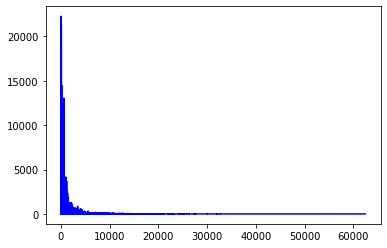



****************************************************************
* My vocabulary reduced to words that happen at least 50 times *
****************************************************************
New vocabulary size reduced to words happening at least 50 times: 2720
Represents a reduction of 95.64374829833918% 



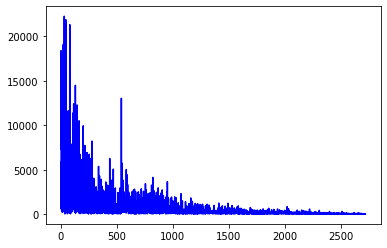



**************************************
* My Vocabulary Tokenizer Statistics *
**************************************
Tokenizer vocabulary size: 2720 (compared to 2720 of the my vocab size)


************************************************
* Training sample of document vs. its encoding *
************************************************
The document and its encoding:
 miss space intern storag gti9195 run lollipop 511 current pacrom theori 8gb intern memori howev cant seem track exact happen space paltri 100 app includ system essenti instal phone start report space move app extern microsd card problem persist even custom rom instal subsequ recent rom updat well factori resetscach wipesetc issu near month now period ive trawl internet suggest clue without make real progress seem larg chunk space phone memori simpli inaccess unus possibl delv deeper what go on ive includ output df command termin emul below notic seem duplic intern memori storageemulated0 storageemulatedlegaci though thin

In [ ]:
# Remove those records that don't have anything in their title
train_sequences, validation_sequences, test_sequences = get_token_sequences(train_data_9,
                                                                            val_data_9,
                                                                            test_data_9,
                                                                            column_to_process = "TitleBody",
                                                                            min_freq = 50)
# Calculate all of the unique values in the training dataset + 1 to account for the OOV token
my_vocab_size_9 = len(set(chain(*train_sequences))) + 1

# Let's check an example of a document and its encoding:
print_marquee("Training sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_9.iloc[1988]['TitleBody']}\n {train_sequences[1988]}")

# Let's check an example of a document and its encoding:
print_marquee("Validation sample of document vs. its encoding")

print(f"The document and its encoding:\n {train_data_9.iloc[1988]['TitleBody']}\n {validation_sequences[1988]}")

### Vectorización

In [ ]:
calculate_document_length_metrics(train_data_9,
                                  val_data_9,
                                  column = "TitleBody")



*****************
* Train Metrics *
*****************
Number of documents: 51370
Min length: 4
Max length: 1611
Mean length: 57.70846797741873
Std Dev of length: 43.59530440123147


***************
* Val Metrics *
***************
Number of documents: 11008
Min length: 6
Max length: 838
Mean length: 56.780341569767444
Std Dev of length: 41.75179079629431


Se usará un padding de 90 dadas estas métricas.

In [ ]:
# Add padding, "post" or "pre"
padding_type = "post"
max_len_vector = 90

train_padded = pad_sequences(train_sequences,
                             maxlen = max_len_vector,
                             padding = padding_type,
                             truncating = padding_type)

val_padded = pad_sequences(validation_sequences,
                           maxlen = max_len_vector,
                           padding = padding_type,
                           truncating = padding_type)

test_padded = pad_sequences(test_sequences,
                            maxlen = max_len_vector,
                            padding = padding_type,
                            truncating = padding_type)


print_marquee("Comparison not-padded vs padded:")
print(f"Not-Padded: \n {train_sequences[2021]} \n\n Padded:\n {train_padded[2021].tolist()}")



************************************
* Comparison not-padded vs padded: *
************************************
Not-Padded: 
 [404, 6, 3, 29, 327, 21, 34, 404, 481, 801, 13, 428, 327, 264, 59, 420, 108, 3, 4, 419, 446, 3, 230, 301, 699, 1270, 6, 162, 354, 355, 112, 492, 152, 70, 384, 1972, 232, 79, 2624, 327, 2, 18, 195, 647, 298, 201, 18, 274, 748, 191, 50, 525, 3, 29, 419, 111, 43, 2, 797, 43, 359] 

 Padded:
 [404, 6, 3, 29, 327, 21, 34, 404, 481, 801, 13, 428, 327, 264, 59, 420, 108, 3, 4, 419, 446, 3, 230, 301, 699, 1270, 6, 162, 354, 355, 112, 492, 152, 70, 384, 1972, 232, 79, 2624, 327, 2, 18, 195, 647, 298, 201, 18, 274, 748, 191, 50, 525, 3, 29, 419, 111, 43, 2, 797, 43, 359, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Preparación final de dataset

In [ ]:
# Let's first prepare the final datasets in the form that will be used for training
X_train = train_padded
y_train = train_data_9["LabelNum"].to_numpy()

X_val = val_padded
y_val = val_data_9["LabelNum"].to_numpy()

X_test = test_padded
y_test = test_data_9["LabelNum"].to_numpy()

print(f"Train final shape X: {X_train.shape}, y: {y_train.shape}")
print(f"Val final shape: X: {X_val.shape}, y: {y_val.shape}")
print(f"Test final shape: X: {X_test.shape}, y: {y_test.shape}")

# Let's see the distribution of the classes
print(f"Percentage of positive classes in Training: {(sum(y_train)/len(y_train)) * 100} %")

print(f"Percentage of positive classes in Val: {(sum(y_val)/len(y_val)) * 100} %")

print(f"Percentage of positive classes in Test: {(sum(y_test)/len(y_test)) * 100} %")

Train final shape X: (51370, 90), y: (51370,)
Val final shape: X: (11008, 90), y: (11008,)
Test final shape: X: (11008, 90), y: (11008,)
Percentage of positive classes in Training: 27.67568619817014 %
Percentage of positive classes in Val: 27.670784883720927 %
Percentage of positive classes in Test: 27.679869186046513 %


## Modelo 1

En este modelo se utiliza la arquitectura más eficiente y más sencilla encontrada durante todos los experimentos anteriores.

Epoch 1/100
1606/1606 [==============================] - 55s 13ms/step - loss: 1.4068 - accuracy: 0.8246 - val_loss: 0.2288 - val_accuracy: 0.9460
Epoch 2/100
1606/1606 [==============================] - 20s 13ms/step - loss: 0.1946 - accuracy: 0.9490 - val_loss: 0.0836 - val_accuracy: 0.9787
Epoch 3/100
1606/1606 [==============================] - 20s 13ms/step - loss: 0.0724 - accuracy: 0.9824 - val_loss: 0.0674 - val_accuracy: 0.9820
Epoch 4/100
1606/1606 [==============================] - 21s 13ms/step - loss: 0.0564 - accuracy: 0.9870 - val_loss: 0.0716 - val_accuracy: 0.9809
Epoch 5/100
1606/1606 [==============================] - 21s 13ms/step - loss: 0.0499 - accuracy: 0.9895 - val_loss: 0.0720 - val_accuracy: 0.9808
Epoch 6/100
1606/1606 [==============================] - 21s 13ms/step - loss: 0.0461 - accuracy: 0.9904 - val_loss: 0.0923 - val_accuracy: 0.9755
Epoch 7/100
1606/1606 [==============================] - 21s 13ms/step - loss: 0.0396 - accuracy: 0.9927 - val_loss: 0

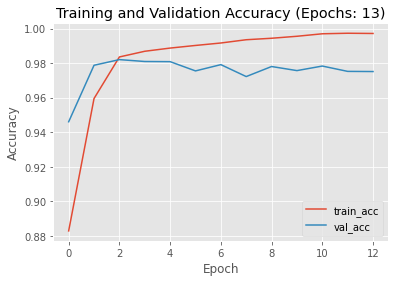

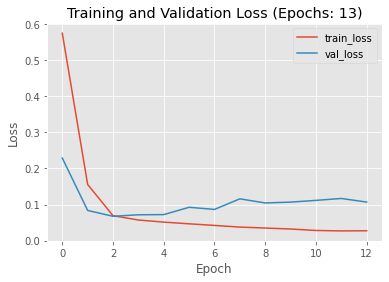

CPU times: user 5min 24s, sys: 23.2 s, total: 5min 47s
Wall time: 5min 12s


In [ ]:
%%time

model = Sequential(name="FinalModel")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_9,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               #kernel_regularizer="l1_l2"
               ))
model.add(LSTM(64))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Modelo 2

El presente modelo es una evolución del anterior que busca ganar un poco más de accuracy usando más complejidad, dropout y regularización.

Se buscará medir por una última vez si un modelo más complejo al mejor encontrado posee un beneficio o no.

Epoch 1/100
1606/1606 [==============================] - 542s 333ms/step - loss: 7.2564 - accuracy: 0.9259 - val_loss: 0.2105 - val_accuracy: 0.9765
Epoch 2/100
1606/1606 [==============================] - 536s 334ms/step - loss: 0.1908 - accuracy: 0.9818 - val_loss: 0.1930 - val_accuracy: 0.9778
Epoch 3/100
1606/1606 [==============================] - 532s 332ms/step - loss: 0.1732 - accuracy: 0.9855 - val_loss: 0.1870 - val_accuracy: 0.9824
Epoch 4/100
1606/1606 [==============================] - 536s 334ms/step - loss: 0.1587 - accuracy: 0.9892 - val_loss: 0.1823 - val_accuracy: 0.9824
Epoch 5/100
1606/1606 [==============================] - 529s 329ms/step - loss: 0.1536 - accuracy: 0.9900 - val_loss: 0.1858 - val_accuracy: 0.9807
Epoch 6/100
1606/1606 [==============================] - 532s 331ms/step - loss: 0.1487 - accuracy: 0.9919 - val_loss: 0.1845 - val_accuracy: 0.9826
Epoch 7/100
1606/1606 [==============================] - 535s 333ms/step - loss: 0.1432 - accuracy: 0.9929

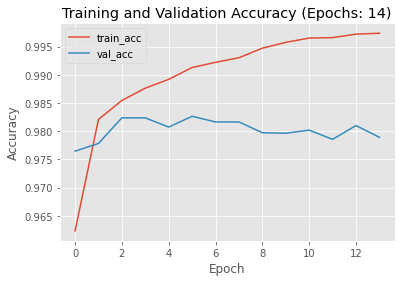

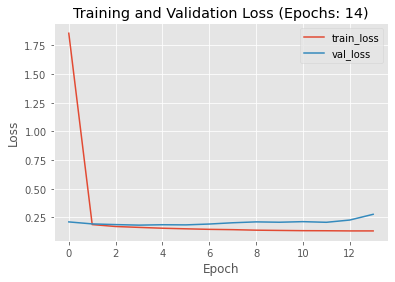

CPU times: user 3h 4min 7s, sys: 21min 32s, total: 3h 25min 39s
Wall time: 2h 5min 17s


In [ ]:
%%time

model = Sequential(name="LstmModelTitleBody")

# embeddidng layer
model.add(Embedding(input_dim=my_vocab_size_9,
                    output_dim = 64,
                    input_length=max_len_vector,
                    embeddings_initializer='uniform'))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
               #kernel_regularizer="l1_l2"

model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               dropout=0.5,
               kernel_regularizer="l1_l2"
               ))
model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               dropout=0.5,
               recurrent_dropout=0.5,
               kernel_regularizer="l1_l2"
               ))
model.add(LSTM(64, return_sequences=True, 
               recurrent_regularizer="l1_l2",
               #kernel_regularizer="l1_l2",
               dropout=0.5
               ))

# Dense layers
model.add(Dense(128, activation = 'relu'))

model.add(Flatten())
model.add(Dense(1, activation= 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

evaluate_model(model,
               epochs=100,
               train_tuple=(X_train, y_train),
               validation_tuple=(X_val, y_val),
               test_tuple = (X_test, y_test),
               callbacks=[EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        verbose=1,
                                        patience=10,
                                        restore_best_weights=True)],
               batch_size=batch_size,
               labels=labels);

## Conclusiones

1. Tamaño vocabulario: 2720 (50 palabras más comunes)
1. Tamaño de batch: 32
1. Tamaño de secuencias: 90
1. Tamaño de embedding: 2720/64 (entrada/salida)
1. Se mantienen sólo tokens de al menos 2 caracteres
1. Se eliminan stopwords pero se preservan palabras negativas en el texto.
1. Longitud de lista de stopwords: 139
1. Regularizador: L1L2 recurrente para modelo 1, y recurrente y kernel para modelo 2
1. Dropout, sólo para modelo 2.
1. Optimizer: Adam

Modelo LSTM | Accuracy (val) |Accuracy (test) | Tiempo entrenamiento (seg)
:---|:---:|:---:|:---:
Simple|0.98|0.98|342.60
Complejo|0.98|0.98|12315.41

Ambos modelos presentan excelentes resultados tanto en accuracy como en sus F1-Score. El modelo está generalizando muy bien a datos no vistos antes. El EarlyStopping se aseguró de capturar los mejores pesos antes de entrar a una curva de sobre-entrenamiento.

Las curvas de accuracy y loss muestran un poco de varianza, pero resulta un tanto más pronunciado en el modelo complejo que usa regularización de kernel, regularización recurrente y dropout.

No se aprecia una diferencia muy significativa entre usar stemmización o no usarla en cuanto a métricas de accuracy se refiere, pero su efecto es claro en un tamaño de vocabulario más reducido que se traduce en tiempos de procesamiento más rápido sin pérdida de información. Esto, aunado a concatenar el title con el body permite obtener la mayor información posible para la correcta clasificación en nuestro dataset.

Dados los resultados y las gráficas, el mejor modelo encontrado para este problema es el Modelo Simple LSTM ya que tiene el mejor accuracy, menos complejidad y el entrenamiento más rápido de toda la experimentación.

## 16

Completa la tabla que se encuentra al final de este documento.

---

### Body con stopwords

Sólo se reportan los mejores modelos

Modelo | Accuracy | Tiempo entrenamiento | Tamaño vocabulario | Total de params | Tamaño de batch | Tamano secuencias | Tamano embedding
:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:
RNN|0.95|12357.37|3655|599,553|32|150|3655/128
GRU|0.97|15041.73|3655|699,009|32|150|3655/128
LSTM|0.97|9327.11|3655|616,065|32|150|3655/128

### Body sin stopwords

Modelo | Accuracy | Tiempo entrenamiento | Tamaño vocabulario | Total de params | Tamaño de batch | Tamano secuencias | Tamano embedding
:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:
RNN|0.96|6173.57|3634|596,865|32|85|3634/128
GRU|0.97|6494.80|3634|696,321|32|85|3634/128
LSTM|0.97|4038.03|3634|613,377|32|85|3634/128

### Title

Modelo | Accuracy | Tiempo entrenamiento | Tamaño vocabulario | Total de params | Tamaño de batch | Tamano secuencias | Tamano embedding
:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:
RNN|0.94|1211.65|4400|314,689|32|6|4400/64
GRU|0.93|531.26|4400|339,841|32|6|4400/64
LSTM|0.94|296.60|4400|356,097|32|6|4400/64

### Body & title

Modelo | Accuracy | Tiempo entrenamiento | Tamaño vocabulario | Total de params | Tamaño de batch | Tamano secuencias | Tamano embedding
:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:
RNN|0.97|8500.58|3764|273,985|32|100|3764/64
GRU|0.98|468.23|3764|299,137|32|100|3764/64
LSTM|0.98|511.06|3764|315,393|32|100|3764/64

### Modelo final

Modelo | Accuracy | Tiempo entrenamiento | Tamaño vocabulario | Total de params | Tamaño de batch | Tamano secuencias | Tamano embedding
:---|:---:|:---:|:---:|:---:|:---:|:---:|:---:
LSTM Simple|0.98|342.60|2720|248,577|32|90|2720/64
LSTM Complejo|0.98|12315.41|2720|375,425|32|90|2720/64




# Conclusiones finales

Se puede observar que el modelo con LSTM simple es el más adecuado para este problema. Además, remover stopwords y realizar stemming en el corpus nos permite obtener un vocabulario más pequeño que usará menos espacio en menoria y menos poder de procesamiento.

El hecho de que el vocabulario sea más pequeño no quiere necesariamente decir que estamos quitándole información al modelo, sino que estamos manteniendo la información más relevante en él.

En el análisis con Body y Title se observva que el vocabulario es más grande por casi 1000 tokens y sin embargo se tienen un accuracy de 98% en los dos modelos.

Tener un vocabulario más pequeño nos permite también reducir el tiempo de entrenamiento siendo el `LSTM Simple` el modelo que tiene mejor accuracy y un tiempo de entrenamiento más pequeño.

Hacer el modelo más complejo no se tradujo en ninguna ganancia efectiva con respecto al modelo LSTM Simple. EarlyStopping fue crucial para mantener el sobre-entrenamiento a raya y obtener los mejores pesos.

Finalmente, la precisión, el recall y por ende el F1-Score se mantiene muy bueno tanto en el dataset de validación como en el de prueba, lo que nos indica que los errores que está cometiendo el modelo son mínimos y que el modelo está generalizando muy bien a datos no vistos antes.